In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')


In [2]:
# uncomment to disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[]


In [3]:
def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
#     weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.02)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[p,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
#             if i * ncol + j in restrained_patches and method != 'unbiased':
#                 for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
#                     pf(ax[i,j],0, color='C3')
#                 ax[i,j].spines['bottom'].set_color('y')
#                 ax[i,j].spines['top'].set_color('y') 
#                 ax[i,j].spines['right'].set_color('y')
#                 ax[i,j].spines['left'].set_color('y')
#                 ax[i,j].spines['left'].set_linewidth(2)
#                 ax[i,j].spines['top'].set_linewidth(2)
#                 ax[i,j].spines['right'].set_linewidth(2)
#                 ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
    plt.tight_layout()


## Reference Model

In [4]:
# Loading trajectory
results=pd.read_csv('Resultscounty.txt',header=None,sep='\t')
results.columns=['ID','time','county','S','E','A','I','R','P','D']
# results=pd.merge(results,parameters,on='ID')
results.sort_values(['ID','time'],ascending=True,inplace=True)
dictionary=pd.read_csv('countydictionary.csv')
dictionary.columns=['COUNTY CODE','COUNTY NAME','county']
results=pd.merge(results,dictionary,on='county')
# results=resultspatch[['time','COUNTY NAME','S','E','A','I','R','P','D','beta','tauexposed','taupresymp','tauI','casefatalityrate','COUNTY CODE']]  
results=results[['ID','time','COUNTY NAME','S','E','A','I','R','P','D']]
results.loc[:,"S":"D"] = results.loc[:,"S":"D"].div(results.loc[:,"S":"D"].sum(axis =1), axis=0)
population =pd.read_csv('popCounty.txt',index_col=False,names=['ID','Population'],header=None,sep=' ')['Population'].tolist()
population_fraction = population/np.sum(population)
area =pd.read_csv('areaCounty.txt',index_col=False,names=['ID','Area'],header=None,sep=' ')['Area'].tolist()
# Getting number of patches
patches = np.unique(results['COUNTY NAME'].values)
M = len(patches)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


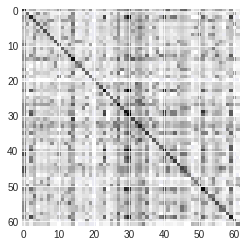

In [5]:
# load mobility matrix
networkCounty=pd.read_csv('networkCounty.txt',header=None,sep=' ')
networkCounty.columns=['ID','County','mobility_parameter']
# mobility_matrix = networkCounty.reset_index().groupby(['County'])['mobility_parameter'].apply(np.array).to_numpy()
# networkCounty = networkCounty[['ID','mobility_parameter']]
mobility_matrix = np.empty([0,M])
mobility_parameter_row = np.zeros(M)
for i,row in networkCounty.iterrows():
    mobility_parameter_row[networkCounty.loc[i, 'County']] = networkCounty.loc[i, 'mobility_parameter']
    if i < networkCounty.shape[0]-1:
        if networkCounty.loc[i+1, 'County'] == 0:
            mobility_matrix = np.append(mobility_matrix, [mobility_parameter_row], axis=0)
    #         print(mobility_parameter_row)
            mobility_parameter_row = np.zeros(M)
    else:
         mobility_matrix = np.append(mobility_matrix, [mobility_parameter_row], axis=0)

assert (np.shape(mobility_matrix)==(M,M))
mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
print (np.sum(mobility_matrix_norm, axis =1))
plt.imshow(np.log(mobility_matrix))

In [6]:
# Getting the time length
time_S = np.unique(results['time'].values)
Time_S = len(time_S)
# Getting number of trajectories
IDs = np.unique(results['ID'].values)
N = len(IDs)
np.set_printoptions(threshold=np.inf)
# Number of compartments
C = 7
ref_traj = np.empty((N, Time_S, M, C))
# start_time = 30
# end_time = 75
for n in IDs:
    for m, patch_name in enumerate(patches):
        ID = results.loc[results['ID'].isin([str(n)])]
        county = ID.loc[ID['COUNTY NAME'] == patch_name]
        traj_county = county[['S','E','A','I','R','P','D']].to_numpy()
        ref_traj[n,:,m,:] = traj_county
           
start_time = 0
end_time = 201  

Time = end_time - start_time
p = 0

## Combining P and D compartments into R
# ref_traj[p,:,:,4] +=  ref_traj[p,:,:,5] + ref_traj[p,:,:,6]
# ref_traj = ref_traj[p,:,:,:5]
# ref_traj = ref_traj[np.newaxis,:,:,:]


In [7]:
# patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
# plt.suptitle("Reference data", size=25, y=1.001)
# plt.tight_layout()
# plt.savefig('patch_quantile.png',dpi=400)
# population[0:10]
# beta = np.array([0.028905,0.052113])
# beta.shape[0]

In [41]:
patches[31]

'Niagara County'

In [8]:
# make a maxentep traj to compare 
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
eta = 1/2.492673
# alpha = 1/4
mu = 1/4.897089
epsilon = 0.586028
tmat.add_transition('E', 'A', 1/eta/(1-epsilon), 0)
tmat.add_transition('E', 'I', 1/eta/epsilon, 0)
tmat.add_transition('A', 'R', 1/mu, 0)
tmat.add_transition('I', 'R', 1/mu, 0)

infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
model = maxentep.MetaModel(infect_fxn, Time, populations=np.array(population))

# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# assume starting from Monroe county
true_p0_node = 31
exposed_origin = 1/population[true_p0_node]
start[true_p0_node,0] = exposed_origin
# start[0,0] = 0.05
beta = np.array([0.028905,0.052113])
ref_traj = model(mobility_matrix_norm, tmat.value, start, beta)[0]
ref_traj = ref_traj[np.newaxis,:,:,:]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Plotting 62 patches in a 7 x 9 grid


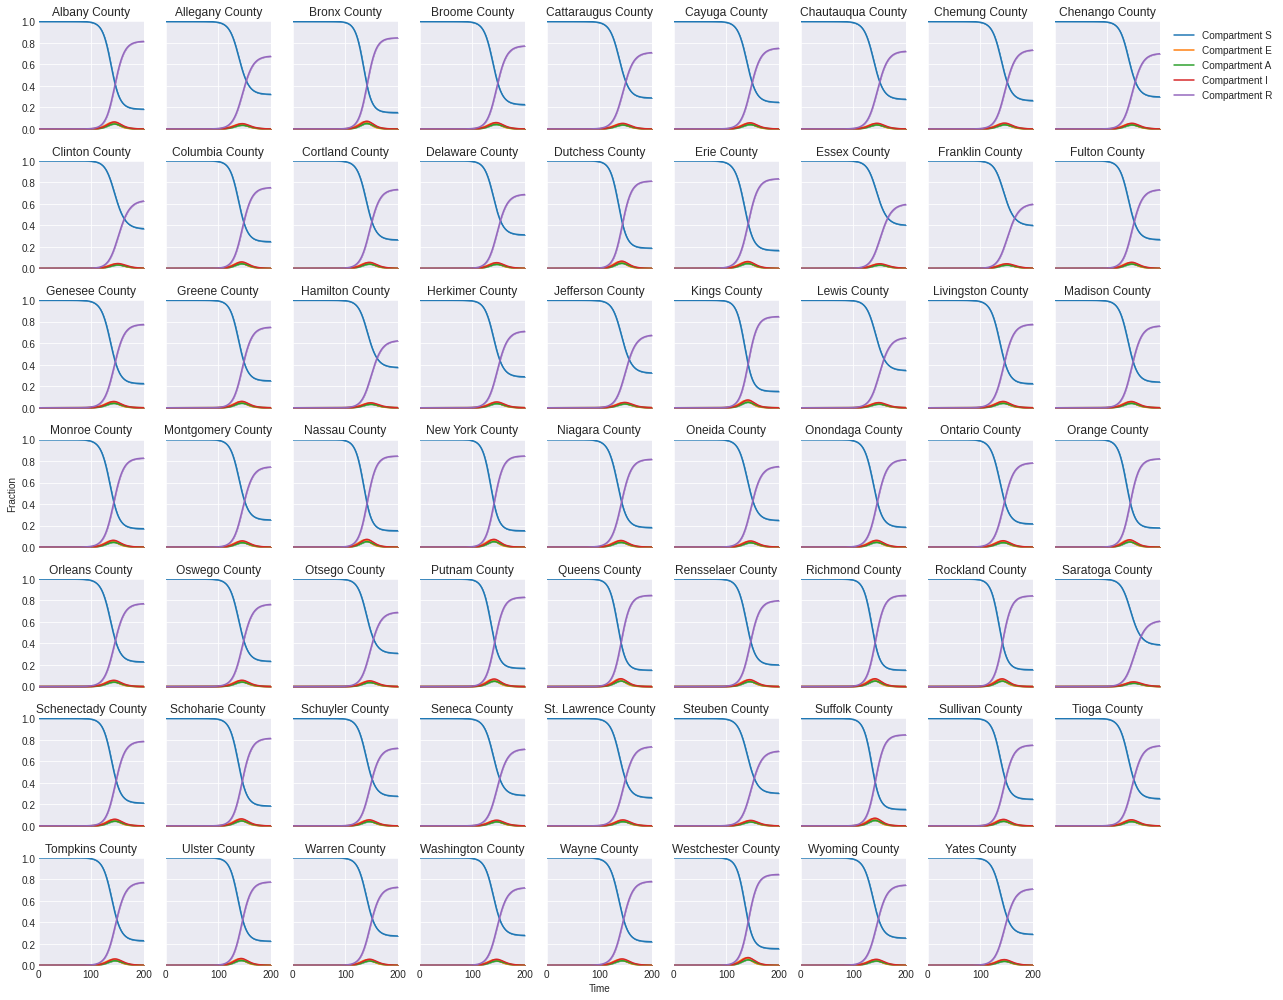

In [9]:
patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])

In [10]:
# patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
# plt.suptitle("Reference data", size=25, y=1.001)
# plt.tight_layout()
# plt.savefig('patch_quantile.png',dpi=400)

In [11]:
# ## make a maxentep traj to compare 
# # compartment parameters
# compartments = ['E', 'A', 'I', 'R']
# full_compartments = ['S'] + compartments
# infections_compartments = [1,2]
# C = len(compartments)
# tmat = maxentep.TransitionMatrix(compartments, [1,2])
# eta = 1/2.6
# alpha = 1/2.6
# mu = 1/3.2
# tmat.add_transition('E', 'A', 1/eta, 0)
# tmat.add_transition('A', 'I', 1/alpha, 0)
# tmat.add_transition('I', 'R', 1/mu, 0)

# infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
# timesteps = 202
# model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

# # starting fractions probabilities
# start = np.zeros((M,C)) #anywhere
# # assume starting from Bronx county
# exposed_Bronx = 1/population[2]
# start[2,0] = exposed_Bronx
# # start[0,0] = 0.05
# beta = 0.04
# m_ref_traj = model(mobility_matrix_norm, tmat.value, start, beta)[0]
# ref_traj = m_ref_traj[np.newaxis,::,:]

# patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])

In [12]:
# patch_quantile(m_ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
# ref_traj = m_ref_traj
# total_pop = np.sum(population)
# R0 = 5
# t_max = np.log(total_pop)/mu/(R0-1)
# t_max

In [13]:
# Run this for creating frames for animations
import plotly.graph_objs as go
import plotly.figure_factory as ff 
process_traj = False
if process_traj == True:
    for t in range(T):
        infected_portion = [tf.round(ref_traj[0,t,i,3],2) for i in range(M)]
        zipcodes = dictionary['COUNTY CODE']
        fig = ff.create_choropleth(fips=zipcodes, 
                                   scope=['New York'],
                                   values=infected_portion,
                                   title='NY COVID-19 Infected Population Fraction by County',
                                   county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
                                   state_outline={'width': .5}
                                   )


        fig.update_layout(legend=dict(
            title='Infected Fraction',
            yanchor="top",
            y=0.95,
            xanchor="left",
            x=0.9,

        ))
        fig.add_annotation(dict(font=dict(color='black',size=30),
                                                x=0.4,
                                                y=0.12,
                                                showarrow=False,
                                                text="Day {}".format(t),
                                                textangle=0,
                                                xanchor='left',
                                                xref="paper",
                                                yref="paper"
                                                ))

        fig.layout.template = {'layout': {'font': {'family': 'Britannic Bold', 'size': 20}}}
        fig.write_image("NY_map//traj_" + str(t) +
                            ".png",width = 2048, height =1060)

# Run this for saving plots
if process_traj == True:
    for i in range(M):
        traj_quantile(ref_traj[:,:,i,:], names=['S','E','A','I','R','P','D'], add_legend=False, add_title = patches[i], plot_means=True)
        fig = plt.gcf()
        fig.set_size_inches(4, 4)
        #plt.savefig('{}.png'.format(patches[i]),dpi=400)
        plt.close()

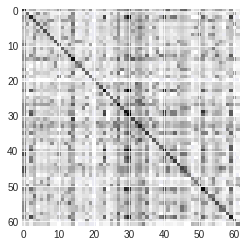

In [14]:
plt.imshow(np.log(mobility_matrix))

## Make restraints from reference trajectory

I R
Restraints are set in this time range: [0, 140]
59 1.9536206e-05 2.021440051017509e-05
45 4.3217983e-06 4.496143108364712e-06
24 3.7633959e-07 3.890623426165228e-07
10 4.132363e-08 4.295420409253688e-08
122 0.014651142 0.015652571963681222
66 4.114039e-05 3.927165205231114e-05
52 9.232552e-06 9.156479426626574e-06
87 0.00038332024 0.00041961524982306363
31 8.8881285e-07 8.59123412425583e-07
136 0.041463464 0.04424241391978175
94 0.0008090584 0.0007887631278611462
129 0.02660519 0.027428596316308288
10 3.9880067e-08 3.902806954980684e-08
94 0.0025056326 0.00262993059072395
122 0.048139505 0.04611348500288067
59 5.9002698e-05 5.598904614242298e-05
45 1.2260912e-05 1.2058160673243038e-05
24 7.8511295e-07 7.949713891295011e-07
115 0.023360664 0.02260551468871089
136 0.17582498 0.18862975168169457
129 0.0954271 0.09812511119834956
80 0.00056390476 0.000548164971935419
31 2.1606288e-06 2.182226866865587e-06
87 0.0011884787 0.0011631453515143538
87 0.00034480373 0.00037528092645370506
136

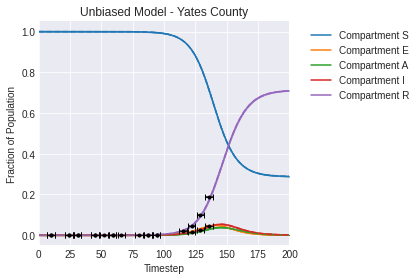

I R
[61  7 22 56 23]
61


In [48]:
compartments = ['E','A','I','R']
infections_compartments = [1,2]
full_compartments = ['S'] + compartments
npoints = 12
# prior = maxentep.EmptyPrior()
prior = maxentep.Laplace(0.1)
# p = 0

# restrained_patches = np.random.randint(M, size=number_of_restraint_patches)
number_of_restrained_patches = 5 
restrained_compartments = [3,4] #(infected patch and recovered)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
print (restrained_compartments_names)
number_of_restrained_compartments = len(restrained_compartments) 

restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)

restrained_patch = restrained_patches[0]

restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches,
                                                    restrained_compartments,ref_traj, prior,npoints=npoints,
                                                    noise=0.05, start_time=0, end_time=140)
maxentep.traj_quantile(ref_traj[:,:,restrained_patch,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[p,:,restrained_patch,:], linestyle='--')
plt.title('Unbiased Model - {}'.format(patches[restrained_patch]))
for i,pf in enumerate(plot_fxns_list[0]):
    pf(plt.gca(), 0)
plt.tight_layout()
plt.savefig('unbiased.png',dpi=200)
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.show()
print (restrained_compartments_names)
print(restrained_patches)
print(restrained_patch)

## Restraining a sample SEAIRPD to reference

In [16]:
print(max(1/np.array(population)))
print(np.mean(1/np.array(population)))
print(np.var(1/np.array(population)))

0.00021222410865874363
1.6059567615649856e-05
7.469191736144403e-10


In [17]:
# compartment parameters
compartments = ['E','A','I','R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
eta = 1/2.492673
# alpha = 1/4
mu = 1/4.897089
# epsilon = 0.6
tmat.add_transition('E', 'A', 5, 2) # call this alpha
tmat.add_transition('E', 'I', 5, 2) # call this gamma
tmat.add_transition('A', 'R',6, 2) # mu
tmat.add_transition('I', 'R', 6, 2) # mu


print(tmat.value)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_low = [0.02]*2
# hyper_pram.beta_low = 0.001
# hyper_pram.beta_high = 0.04
hyper_pram.beta_high = [0.08]*2
hyper_pram.beta_var = [0.5]*2
# hyper_pram.start_high = 2e-4
hyper_pram.start_high = 2e-4
hyper_pram.R_var = 10
hyper_pram.beta_start = 0.04
hyper_pram.start_mean = 5e-5
hyper_pram.start_scale = 1e-7

start_logits = np.zeros((M))
param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model', hypers = hyper_pram, n_infectious_compartments=2)

[[0.6        0.2        0.2        0.        ]
 [0.         0.83333333 0.         0.16666667]
 [0.         0.         0.83333333 0.16666667]
 [0.         0.         0.         1.        ]]


In [18]:
intial_exposed_guess = 1/np.array(population)
v = param_model.sample(10)
beta_dist = v[3]
# start_dist
# mask = tf.greater(start_dist, 0)
# start_exposed_dist = tf.boolean_mask(start_dist, mask).numpy()
# tf.reduce_mean(start_exposed_dist)
start_dist = v[2]
start_dist

<tf.Tensor: shape=(10, 62, 4), dtype=float32, numpy=
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.

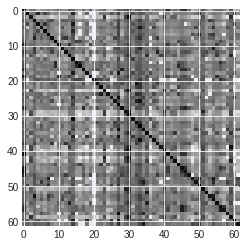

In [19]:
# Making sure our sample for mobility network is reasonable
R = v[0][8]
plt.imshow(np.log(R))

In [20]:
intial_exposed_guess = 1/np.array(population)
import tqdm
# N = 16384
N = 8192
batches = 16
total_batches= N*batches
outs = []
infect = maxentep.contact_infection_func(infections_compartments, area = area)
# model = maxentep.MetaModel(infect, Time,populations = np.round(population))
model = maxentep.MetaModel(infect, Time, populations = population)
prior_prams = []
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
#     R_dist= ps[0]
#     output_list = []
#     for i in range(R_dist.shape[0]):
#         R_dist_d = mobility_matrix
#         norm_R_dist_d = R_dist_d/ tf.math.reduce_sum(R_dist_d, axis = 1, keepdims=True)
#         output_list.append(norm_R_dist_d)
#     outputs = tf.stack(output_list)
#     ps[0] = outputs
#     start_dist = ps[2]
#     new_start_dist = np.zeros_like(start_dist)
#     start_dist_list = []
#     for i in range(start_dist.shape[0]):
#         index = tf.where(start_dist[i]>0)[0][0].numpy()
#         new_start_dist[i,index,0] = intial_exposed_guess[index]
#     start_dist_list.append(new_start_dist)
#     outputs = tf.stack(start_dist_list, axis =0)
#     ps[2] = tf.squeeze(outputs)
    prior_prams.append(ps)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
# trajs = trajs[:,start_time:end_time,:,:]
print(trajs.shape)

100%|██████████| 16/16 [10:14<00:00, 38.43s/it]


(131072, 201, 62, 5)


## Visualizing the unbiased traj

Plotting 62 patches in a 7 x 9 grid


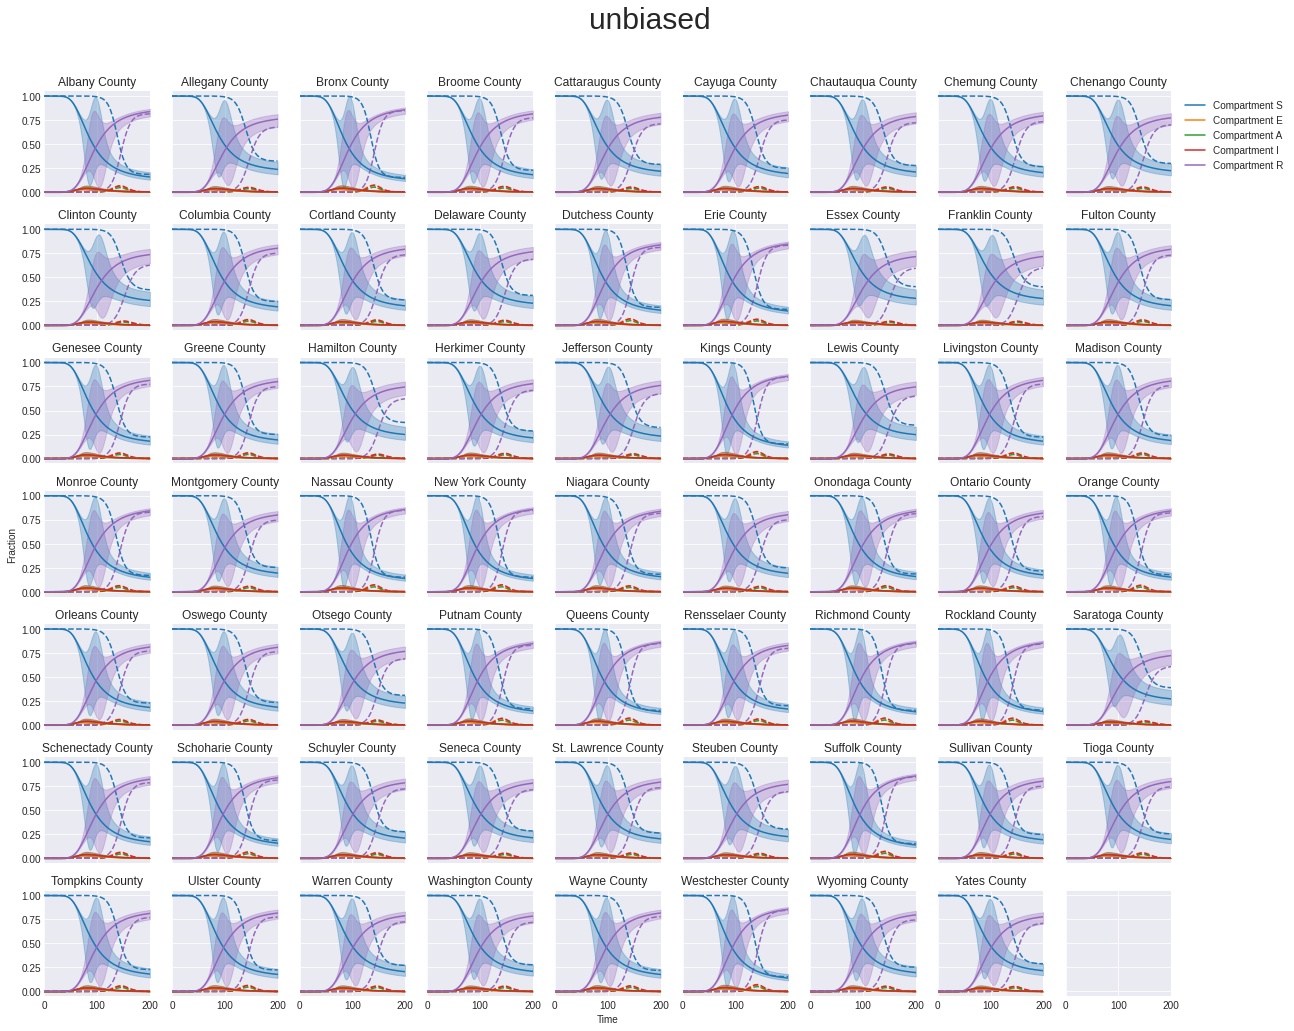

In [21]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
compare_to_ref(ref_traj,trajs, weights=None, method='unbiased', patch_names = patches, 
               figsize=(18, 14), alpha=0.3, names=full_compartments)

<AxesSubplot:ylabel='Count'>

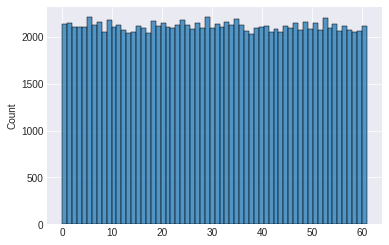

In [22]:
prior_exposed_patch = maxentep.exposed_finder(trajs)
sns.histplot(x=prior_exposed_patch, label='Prior', color='C0',bins=M)

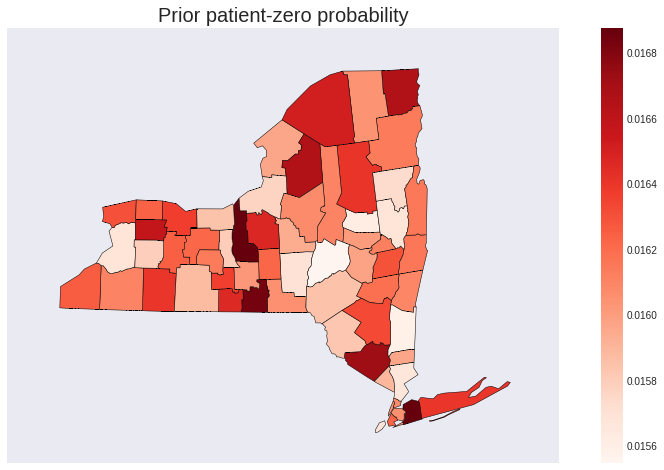

In [23]:
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability',
                fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')

In [24]:
def get_dist(prior_prams):
    R_dist = []
    T_dist = []
    start_dist = []
    beta_dist = []
    for i in range(len(prior_prams)):
        param_batch = prior_prams[i]
#         R_dist.append(param_batch[0])
        T_dist.append(param_batch[1])
        start_dist.append(param_batch[2])
        beta_dist.append(param_batch[3])
#     R_dist = tf.concat(R_dist, axis = 0)
    T_dist = tf.concat(T_dist, axis = 0)
    start_dist = tf.concat(start_dist, axis = 0)
    beta_dist = tf.concat(beta_dist, axis = 0)
    # get eta^-1
    E_A = 1/T_dist[:, compartments.index('E'), compartments.index('A')].numpy()
    # get gamma^-1
    E_I = 1/T_dist[:, compartments.index('E'), compartments.index('I')].numpy()
    # get mu^-1
    A_R = 1/T_dist[:, compartments.index('A'), compartments.index('R')].numpy()
    # get mu^-1
    I_R = 1/T_dist[:, compartments.index('I'), compartments.index('R')].numpy()
    # Getting starting exposed fraction 
    mask = tf.greater(start_dist, 0)
    start_exposed_dist = tf.boolean_mask(start_dist, mask).numpy()
    return [E_A, E_I,A_R, I_R, start_exposed_dist, beta_dist]
    
def plot_dist(E_A, E_I, A_R, I_R, start_exposed_dist, beta_dist, name='Prior'):
    import seaborn as sns
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,6), dpi=200)
    fig.suptitle(f'{name} distributions', fontsize=25,y=1.00)
    sns.distplot(x=beta_dist[...,0], ax = axs[0,0], axlabel=r'$\beta_{A}$')
    sns.distplot(x=beta_dist[...,1], ax = axs[0,1], axlabel=r'$\beta_{I}$')
    sns.distplot(x=E_A, ax = axs[0,2], axlabel=r'$\alpha^{-1}$ : E->A (days)')
    sns.distplot(x=E_I, ax = axs[1,0], axlabel=r'$\gamma^{-1}$ : E->I (days)')
    sns.distplot(x=A_R, ax = axs[1,1], axlabel=r'$\mu_{A}^{-1}$ : A->R (days)')
    sns.distplot(x=I_R, ax = axs[1,2], axlabel=r'$\mu_{I}^{-1}$ : I->R (days)')
#     sns.distplot(x=E_A, ax = axs[1,0], axlabel=r'$\eta^{-1}$ : E->A (days)')
#     sns.distplot(x=A_I, ax = axs[1,1], axlabel=r'$\alpha ^{-1}$ : A->I (days)')
#     sns.distplot(x=I_R, ax = axs[1,1], axlabel=r'$\mu^{-1}$ : I->R (days)')

In [25]:
prior_param_dist = get_dist(prior_prams)
E_A, E_I, A_R, I_R, start_exposed_dist, beta_dist = prior_param_dist

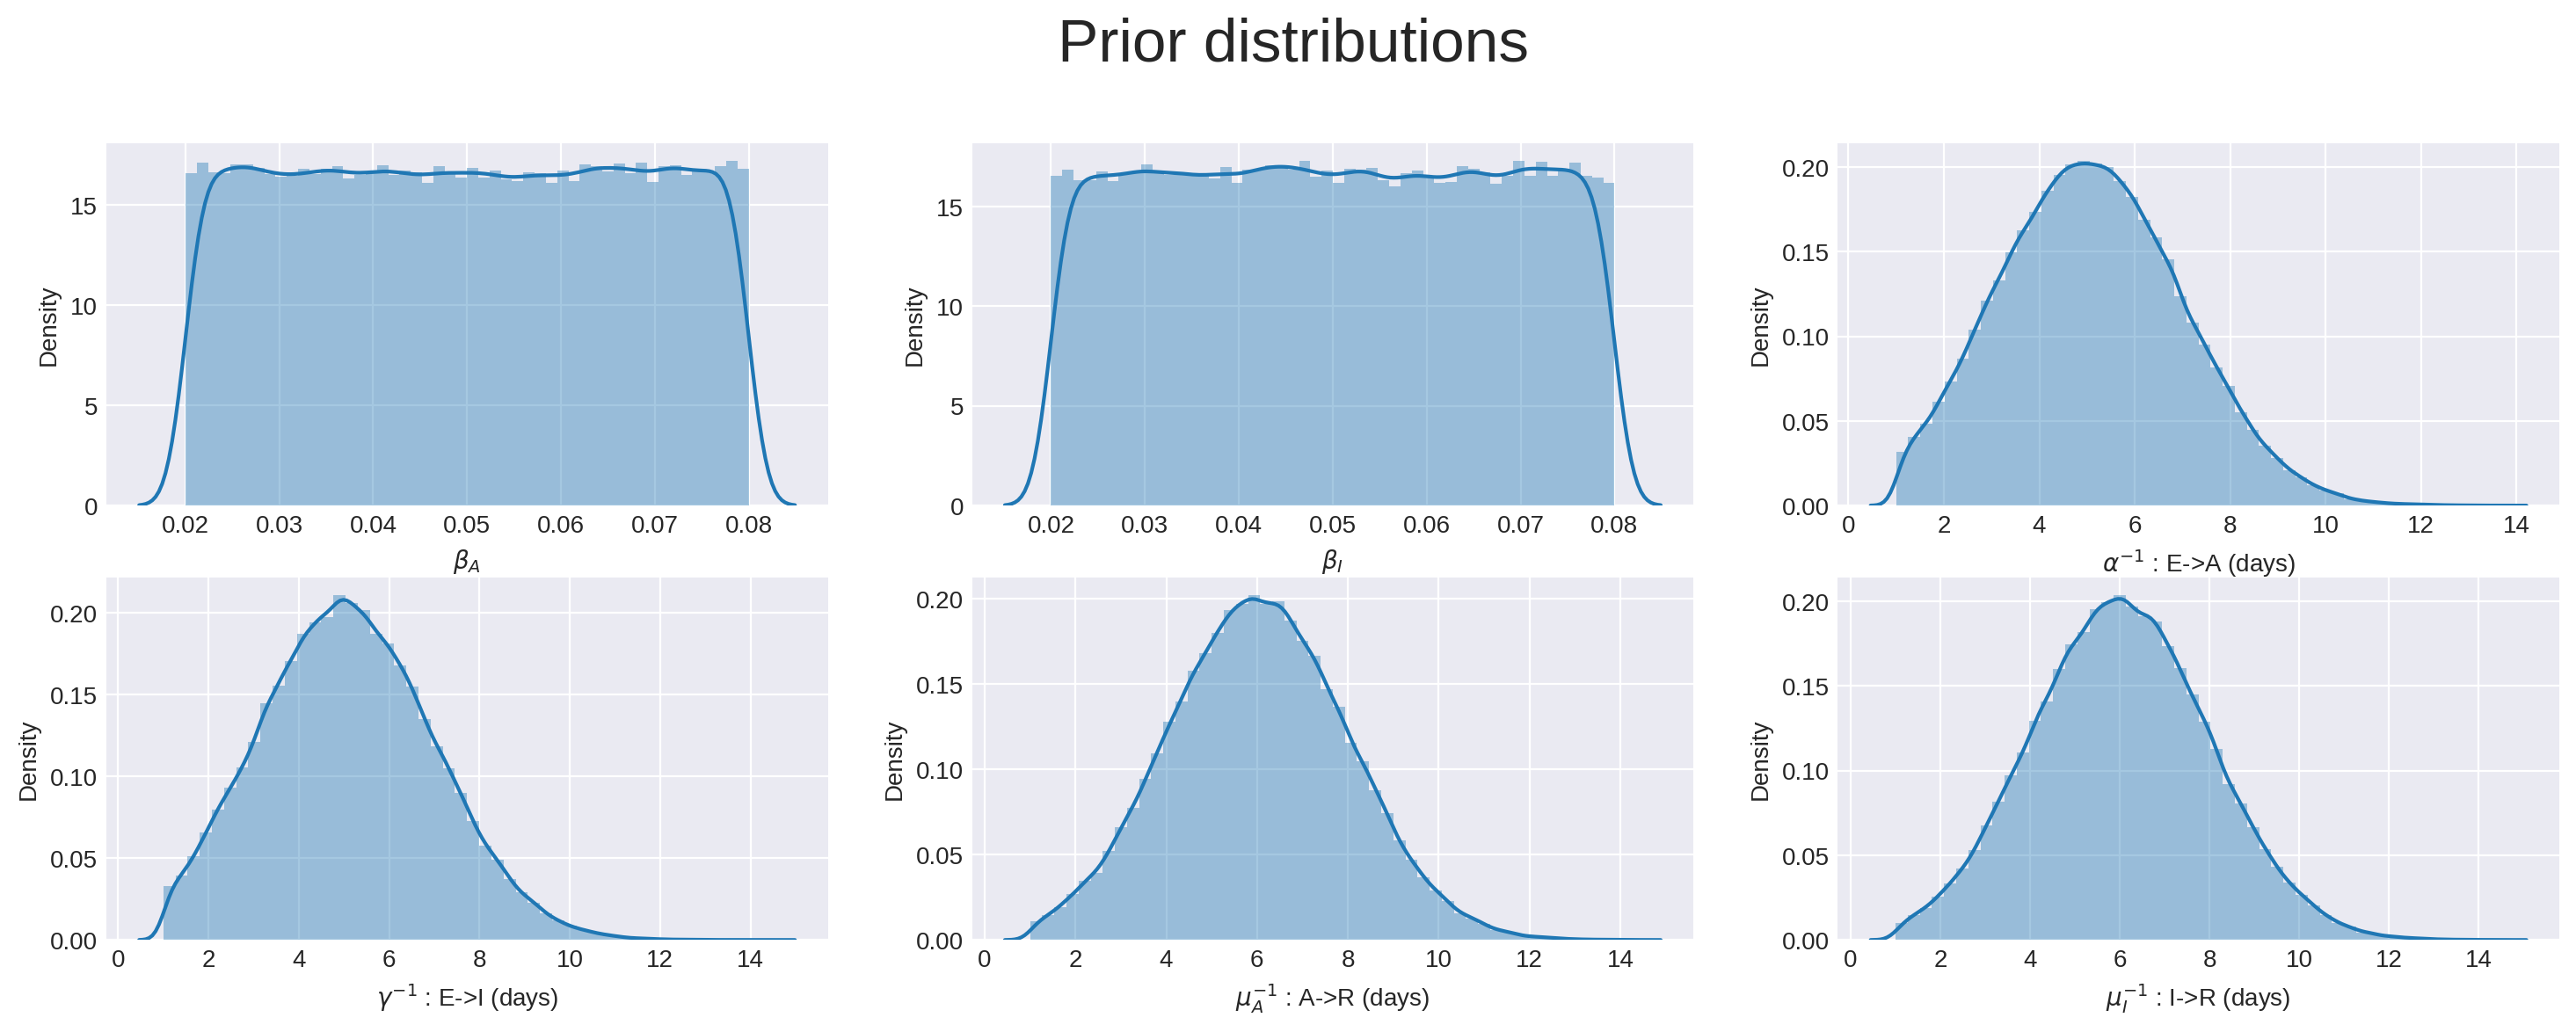

In [26]:
plot_dist(*prior_param_dist)

In [27]:
# ref_traj = tf.squeeze(ref_traj)
# if tf.rank(ref_traj).numpy() != 4:
#     ref_traj = ref_traj[tf.newaxis, ...]
# ref_traj.shape

In [28]:

# print (restrained_compartments_names)
# npoints =4
# prior = maxentep.EmptyPrior()
# cutting the ref_traj in half
# restraints_R, plot_fxn_R = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [restrained_patch,4], npoints, prior, noise=0,time_average=7)
#restraints_E, plot_fxn_E = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,1], npoints, prior, noise=0,time_average=7)
#restraints_A, plot_fxn_A = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,2], npoints, prior, noise=0,time_average=7)
# restraints_I, plot_fxn_I = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [restrained_patch,3], npoints, prior, noise=0,time_average=7)
#restraints_P, plot_fxn_P = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,5], npoints, prior, noise=0,time_average=7)
#restraints_D, plot_fxn_D = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,6], npoints, prior, noise=0,time_average=7)
#restraints = restraints_R + restraints_E + restraints_A + restraints_I + restraints_P + restraints_D
#plot_fxns = plot_fxn_R + plot_fxn_E + plot_fxn_A + plot_fxn_I + plot_fxn_P + plot_fxn_D
# restraints = restraints_I + restraints_R
# plot_fxns = plot_fxn_I + plot_fxn_R


In [49]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')

In [50]:
# class CustomCallback(tf.keras.callbacks.Callback):
#     def __init__(self):
#         self. i = 0
#     def on_epoch_begin(self, epoch, logs=None):
#         self.i += 1
#         return self.i
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9,
                              patience=5, min_lr=0)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, min_delta=0)

In [51]:
me_history = me_model.fit(trajs, batch_size=N, epochs=1000, callbacks=[reduce_lr])#, callbacks=[CustomCallback()])

Epoch 1/1000
16/16 [==============================] - 0s 4ms/step - loss: 18.3375 - weight-entropy: 0.7845
Epoch 2/1000
16/16 [==============================] - 0s 4ms/step - loss: 6.9656 - weight-entropy: 0.3320
Epoch 3/1000
16/16 [==============================] - 0s 4ms/step - loss: 8.6190 - weight-entropy: 0.1773
Epoch 4/1000
16/16 [==============================] - 0s 3ms/step - loss: 7.6533 - weight-entropy: 0.2412
Epoch 5/1000
16/16 [==============================] - 0s 4ms/step - loss: 5.1803 - weight-entropy: 0.3396
Epoch 6/1000
16/16 [==============================] - 0s 4ms/step - loss: 8.1114 - weight-entropy: 0.1546
Epoch 7/1000
16/16 [==============================] - 0s 4ms/step - loss: 4.7421 - weight-entropy: 0.2289
Epoch 8/1000
16/16 [==============================] - 0s 4ms/step - loss: 6.0538 - weight-entropy: 0.3243
Epoch 9/1000
16/16 [==============================] - 0s 3ms/step - loss: 23.1349 - weight-entropy: 0.3474
Epoch 10/1000
16/16 [=======================

16/16 [==============================] - 0s 4ms/step - loss: 2.6705 - weight-entropy: 0.2375
Epoch 78/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.5573 - weight-entropy: 0.1660
Epoch 79/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.4948 - weight-entropy: 0.1356
Epoch 80/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.4535 - weight-entropy: 0.1807
Epoch 81/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.5646 - weight-entropy: 0.1885
Epoch 82/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.5990 - weight-entropy: 0.1972
Epoch 83/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.5770 - weight-entropy: 0.1610
Epoch 84/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.4859 - weight-entropy: 0.0767
Epoch 85/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.4711 - weight-entropy: 0.3285
Epoch 86/1000
16/16 [==============================

16/16 [==============================] - 0s 4ms/step - loss: 2.7667 - weight-entropy: 0.1643
Epoch 154/1000
16/16 [==============================] - 0s 5ms/step - loss: 2.2268 - weight-entropy: 0.1680
Epoch 155/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.4049 - weight-entropy: 0.2638
Epoch 156/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.2101 - weight-entropy: 0.0939
Epoch 157/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.3350 - weight-entropy: 0.1142
Epoch 158/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2712 - weight-entropy: 0.0786
Epoch 159/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.4068 - weight-entropy: 0.1236
Epoch 160/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.0176 - weight-entropy: 0.1114
Epoch 161/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.3014 - weight-entropy: 0.1210
Epoch 162/1000
16/16 [=====================

Epoch 229/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.5502 - weight-entropy: 0.1862
Epoch 230/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.1765 - weight-entropy: 0.2637
Epoch 231/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.5504 - weight-entropy: 0.1249
Epoch 232/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.6116 - weight-entropy: 0.1408
Epoch 233/1000
16/16 [==============================] - 0s 3ms/step - loss: 1.8151 - weight-entropy: 0.2371
Epoch 234/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.4591 - weight-entropy: 0.1179
Epoch 235/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.0190 - weight-entropy: 0.1985
Epoch 236/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.0665 - weight-entropy: 0.1860
Epoch 237/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.0996 - weight-entropy: 0.1983
Epoch 238/1000
16/16 [======

16/16 [==============================] - 0s 3ms/step - loss: 2.3375 - weight-entropy: 0.2341
Epoch 305/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.1731 - weight-entropy: 0.1443
Epoch 306/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.4737 - weight-entropy: 0.1217
Epoch 307/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.1081 - weight-entropy: 0.3316
Epoch 308/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.0538 - weight-entropy: 0.1676
Epoch 309/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2906 - weight-entropy: 0.1785
Epoch 310/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2879 - weight-entropy: 0.0919
Epoch 311/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.1570 - weight-entropy: 0.0917
Epoch 312/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.7149 - weight-entropy: 0.1815
Epoch 313/1000
16/16 [=====================

Epoch 380/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.4652 - weight-entropy: 0.0985
Epoch 381/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.4028 - weight-entropy: 0.1536
Epoch 382/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2335 - weight-entropy: 0.1874
Epoch 383/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.1617 - weight-entropy: 0.2028
Epoch 384/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.4643 - weight-entropy: 0.1021
Epoch 385/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.1651 - weight-entropy: 0.0611
Epoch 386/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.3737 - weight-entropy: 0.1086
Epoch 387/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.0890 - weight-entropy: 0.2461
Epoch 388/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2975 - weight-entropy: 0.1080
Epoch 389/1000
16/16 [======

16/16 [==============================] - 0s 3ms/step - loss: 2.2688 - weight-entropy: 0.1238
Epoch 456/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.1400 - weight-entropy: 0.1330
Epoch 457/1000
16/16 [==============================] - 0s 3ms/step - loss: 1.8176 - weight-entropy: 0.2351
Epoch 458/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2181 - weight-entropy: 0.1815
Epoch 459/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.5588 - weight-entropy: 0.2314
Epoch 460/1000
16/16 [==============================] - 0s 4ms/step - loss: 1.8350 - weight-entropy: 0.1093
Epoch 461/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.6054 - weight-entropy: 0.2278
Epoch 462/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2191 - weight-entropy: 0.1423
Epoch 463/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2781 - weight-entropy: 0.1679
Epoch 464/1000
16/16 [=====================

Epoch 531/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.4692 - weight-entropy: 0.2418
Epoch 532/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2512 - weight-entropy: 0.0635
Epoch 533/1000
16/16 [==============================] - 0s 4ms/step - loss: 1.8872 - weight-entropy: 0.1562
Epoch 534/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.5570 - weight-entropy: 0.1612
Epoch 535/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.0915 - weight-entropy: 0.2104
Epoch 536/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.1517 - weight-entropy: 0.1314
Epoch 537/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.0319 - weight-entropy: 0.1003
Epoch 538/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.0378 - weight-entropy: 0.2697
Epoch 539/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.0684 - weight-entropy: 0.0693
Epoch 540/1000
16/16 [======

16/16 [==============================] - 0s 4ms/step - loss: 2.1846 - weight-entropy: 0.0417
Epoch 607/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.1495 - weight-entropy: 0.1540
Epoch 608/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.4943 - weight-entropy: 0.1557
Epoch 609/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.0951 - weight-entropy: 0.2170
Epoch 610/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.4866 - weight-entropy: 0.1560
Epoch 611/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.6354 - weight-entropy: 0.1279
Epoch 612/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2477 - weight-entropy: 0.0909
Epoch 613/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2790 - weight-entropy: 0.1376
Epoch 614/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.6102 - weight-entropy: 0.1300
Epoch 615/1000
16/16 [=====================

Epoch 682/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.7970 - weight-entropy: 0.0895
Epoch 683/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.4432 - weight-entropy: 0.1500
Epoch 684/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.6812 - weight-entropy: 0.1266
Epoch 685/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.0598 - weight-entropy: 0.1747
Epoch 686/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.1026 - weight-entropy: 0.1301
Epoch 687/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.5815 - weight-entropy: 0.1549
Epoch 688/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2189 - weight-entropy: 0.1409
Epoch 689/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.3545 - weight-entropy: 0.2271
Epoch 690/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.0747 - weight-entropy: 0.2597
Epoch 691/1000
16/16 [======

16/16 [==============================] - 0s 3ms/step - loss: 2.5974 - weight-entropy: 0.0681
Epoch 758/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2103 - weight-entropy: 0.0885
Epoch 759/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.0160 - weight-entropy: 0.1681
Epoch 760/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.1948 - weight-entropy: 0.1200
Epoch 761/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.0231 - weight-entropy: 0.1640
Epoch 762/1000
16/16 [==============================] - 0s 3ms/step - loss: 1.9672 - weight-entropy: 0.1609
Epoch 763/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.2115 - weight-entropy: 0.2288
Epoch 764/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.3198 - weight-entropy: 0.2872
Epoch 765/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.3090 - weight-entropy: 0.1369
Epoch 766/1000
16/16 [=====================

Epoch 833/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.0057 - weight-entropy: 0.0368
Epoch 834/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.4053 - weight-entropy: 0.1907
Epoch 835/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.1524 - weight-entropy: 0.1824
Epoch 836/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.1440 - weight-entropy: 0.2309
Epoch 837/1000
16/16 [==============================] - 0s 3ms/step - loss: 1.9294 - weight-entropy: 0.1555
Epoch 838/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2171 - weight-entropy: 0.0938
Epoch 839/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2285 - weight-entropy: 0.1015
Epoch 840/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.7485 - weight-entropy: 0.1370
Epoch 841/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.0848 - weight-entropy: 0.0697
Epoch 842/1000
16/16 [======

16/16 [==============================] - 0s 3ms/step - loss: 2.3517 - weight-entropy: 0.0739
Epoch 909/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2227 - weight-entropy: 0.0742
Epoch 910/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.0732 - weight-entropy: 0.1089
Epoch 911/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.3523 - weight-entropy: 0.1524
Epoch 912/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2824 - weight-entropy: 0.0877
Epoch 913/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.3564 - weight-entropy: 0.1802
Epoch 914/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2769 - weight-entropy: 0.0452
Epoch 915/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2571 - weight-entropy: 0.2207
Epoch 916/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.2509 - weight-entropy: 0.1071
Epoch 917/1000
16/16 [=====================

Epoch 984/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.0924 - weight-entropy: 0.1341
Epoch 985/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.0025 - weight-entropy: 0.1836
Epoch 986/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.3850 - weight-entropy: 0.1901
Epoch 987/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.4093 - weight-entropy: 0.0978
Epoch 988/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.1315 - weight-entropy: 0.2332
Epoch 989/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.7852 - weight-entropy: 0.1565
Epoch 990/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.7331 - weight-entropy: 0.1367
Epoch 991/1000
16/16 [==============================] - 0s 3ms/step - loss: 2.0294 - weight-entropy: 0.0853
Epoch 992/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.2437 - weight-entropy: 0.1034
Epoch 993/1000
16/16 [======

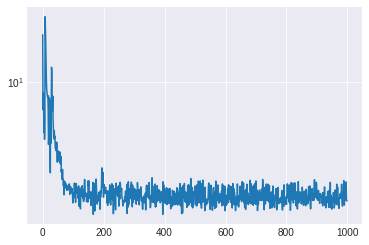

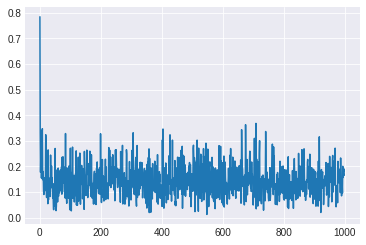

In [52]:
plt.plot(me_history.history['loss'])
plt.yscale('log')
plt.show()
plt.plot(me_history.history['weight-entropy'])
plt.show()

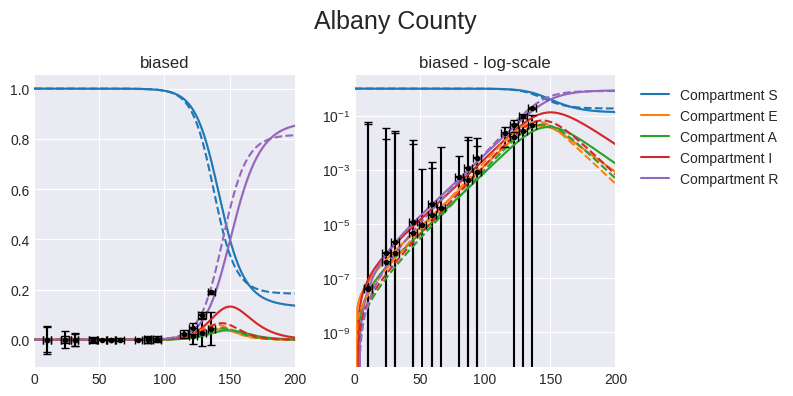

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, dpi = 100, figsize=(8,4))
patch_number = 0
for j in range(2):
    maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights,alpha=0.2, names=full_compartments, ax=ax[j])
    ax[j].plot(ref_traj[p,:,patch_number,:], linestyle='--')
    for i,pf in enumerate(plot_fxns_list[patch_number]):
        pf(ax[j], me_model.lambdas[i], color='k')
    plt.tight_layout()
    ax[j].set_title('biased')
ax[0].get_legend().remove()
ax[1].set_title('biased - log-scale')
ax[1].set_yscale('log')
plt.suptitle(f'{patches[patch_number]}', fontsize=18)
plt.tight_layout()

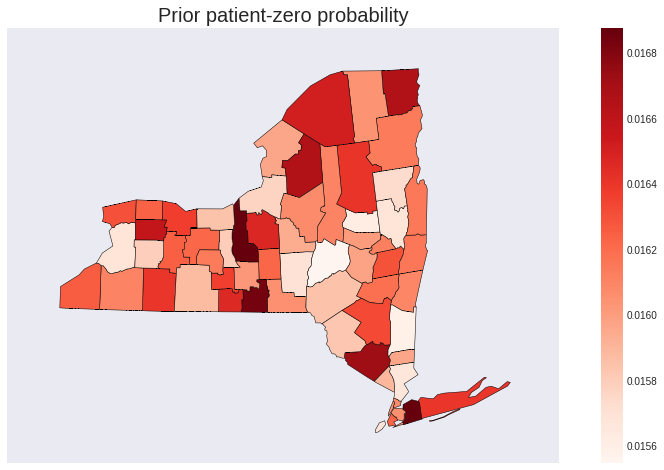

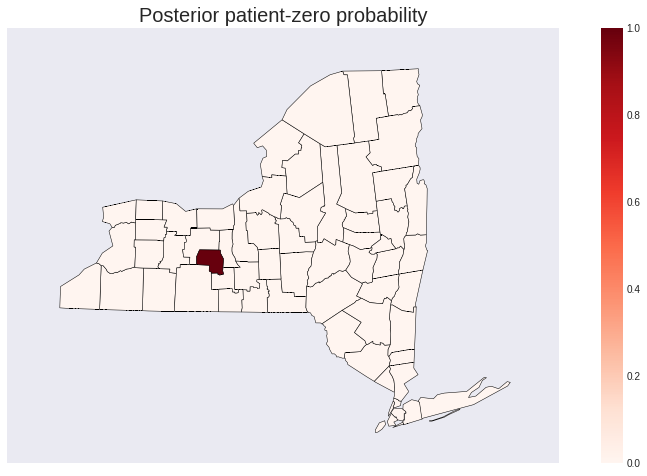

In [54]:
me_w = me_model.traj_weights
prior_exposed_patch = maxentep.exposed_finder(trajs)
posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')
maxentep.p0_map(prior_exposed_patch, M, weights = me_w, title = 'Posterior patient-zero probability', patch_names=patches, fontsize=20
      , choropleth=True, geojson='counties_ny.geojson')

In [35]:
print(np.where(patches=='Franklin County'))
posterior_exposed_prob[16]

(array([16]),)


0.0

In [36]:
sorted(zip(prior_exposed_patch, patches), reverse=True)[:5]

[(60, 'Washington County'),
 (60, 'Tioga County'),
 (60, 'Lewis County'),
 (60, 'Albany County'),
 (59, 'Rensselaer County')]

In [37]:
sorted(zip(posterior_exposed_prob, patches), reverse=True)[:5]

[(0.9999999999994313, 'Orleans County'),
 (5.686852220383431e-13, 'Genesee County'),
 (1.3340122255330843e-23, 'Wyoming County'),
 (3.746463311138509e-27, 'Livingston County'),
 (2.410773661220992e-27, 'Allegany County')]

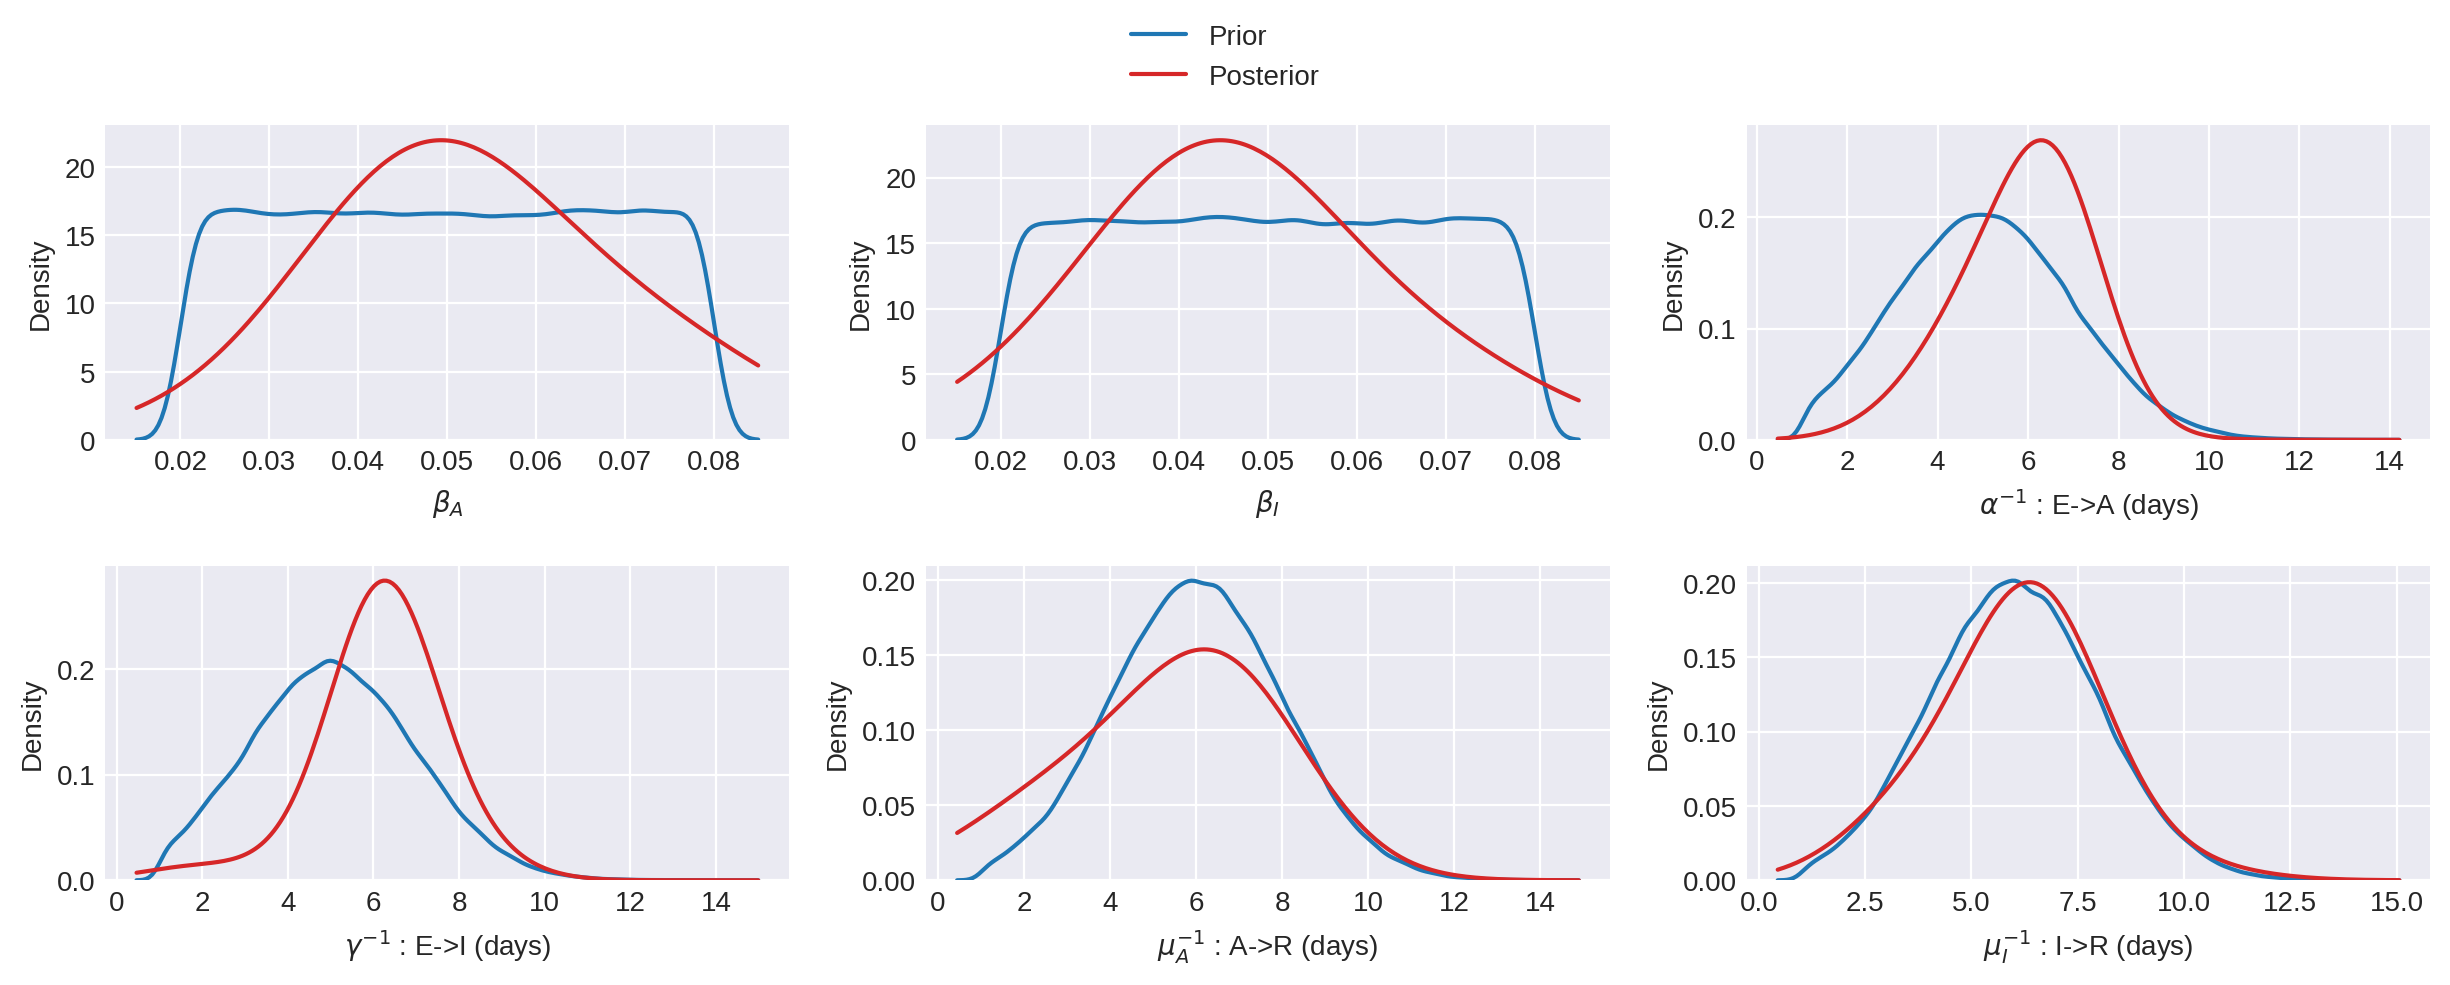

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.kdeplot(x=np.squeeze(beta_dist[...,0]), label='Prior',
            color='C0', ax=axs[0,0])
sns.kdeplot(x=np.squeeze(beta_dist[...,0]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0])
# sns.histplot(x=np.squeeze(beta_dist), weights=hme_model.traj_weights, label='Posterior',
#             color='C3', ax=axs[0,0], stat="density",kde=True)
axs[0,0].set_xlabel(r'$\beta_{A}$')
sns.kdeplot(x=np.squeeze(beta_dist[...,1]), label='Prior',
            color='C0', ax=axs[0,1])
sns.kdeplot(x=np.squeeze(beta_dist[...,1]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1])
axs[0,1].set_xlabel(r'$\beta_{I}$')

# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)
sns.kdeplot(x=np.squeeze(E_A), label='Prior',
            color='C0', ax=axs[0,2])
sns.kdeplot(x=np.squeeze(E_A), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2])
axs[0,2].set_xlabel(r'$\alpha^{-1}$ : E->A (days)')

sns.kdeplot(x=np.squeeze(E_I), label='Prior',
            color='C0', ax=axs[1,0])
sns.kdeplot(x=np.squeeze(E_I), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0])
axs[1,0].set_xlabel(r'$\gamma ^{-1}$ : E->I (days)')

sns.kdeplot(x=np.squeeze(A_R), label='Prior',
            color='C0', ax=axs[1,1])
sns.kdeplot(x=np.squeeze(A_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1])
axs[1,1].set_xlabel(r'$\mu_{A}^{-1}$ : A->R (days)')

sns.kdeplot(x=np.squeeze(I_R), label='Prior',
            color='C0', ax=axs[1,2])
sns.kdeplot(x=np.squeeze(I_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,2],legend=False)
axs[1,2].set_xlabel(r'$\mu_{I}^{-1}$ : I->R (days)')

handles, labels = axs[0,0].get_legend_handles_labels()
# axs[1,2].get_legend().set_visible(False)
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.4)
# axs[-1, -1].axis('off')
# plt.legend()
# plt.savefig('compare_param_dist.png', dpi=300)

<AxesSubplot:xlabel='$w$', ylabel='Density'>

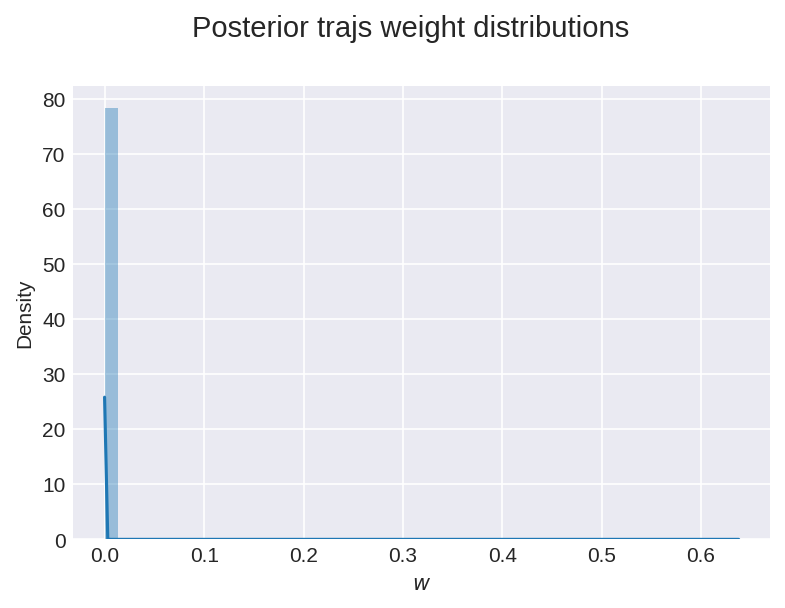

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
fig.suptitle(f'Posterior trajs weight distributions', fontsize=14,y=1.00)
sns.distplot(x=me_w, ax = axs, axlabel=r'$w$')

Plotting 62 patches in a 7 x 9 grid


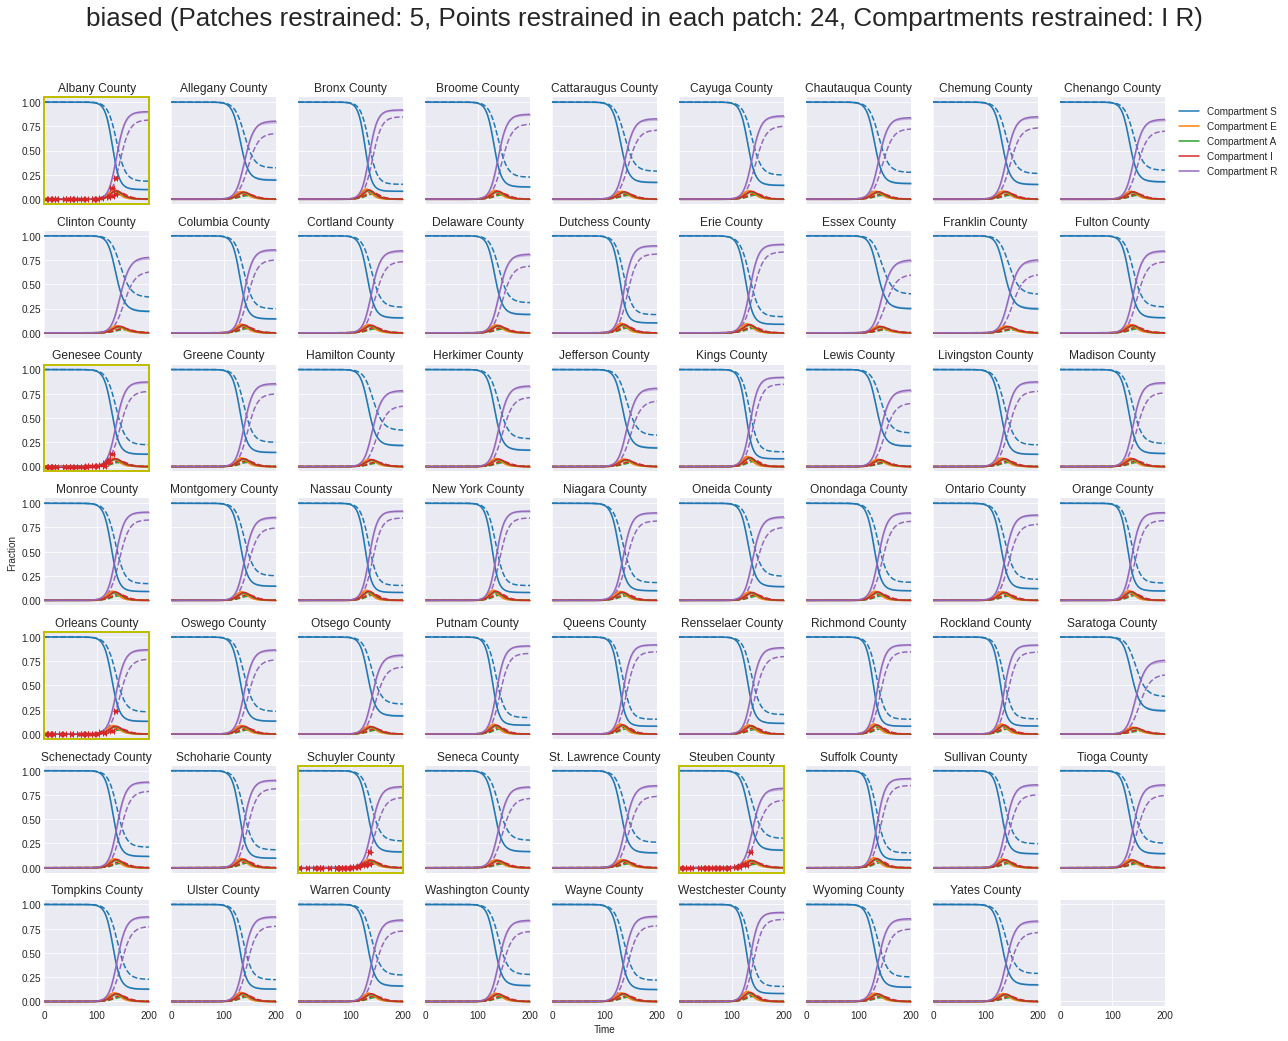

In [40]:
weights_dict = {'unbiased':None, 'biased':me_model.traj_weights, 'hyper-biased':None, 'regression':None }
from matplotlib.patches import Patch
def compare_patches(ref_traj, trajs,weights_dict, method ,*args, figsize=(18, 18), patch_names=None, log_scale=False,** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[p,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if log_scale:
                ax[i,j].set_yscale('log')
                ax[i,j].set_ylim([1e-4, 1])
    plt.tight_layout()

compare_patches(ref_traj,trajs,weights_dict,'biased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()

## Algorithm 2

In [38]:
fit_param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model',hypers = hyper_pram,  n_infectious_compartments=2)
fit_param_model.compile(tf.optimizers.SGD(1))

hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.SGD(learning_rate=1), 'mean_squared_error')

In [38]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=3, param_epochs=50, batch_size=N, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0702 - weight-entropy: 9.7041
Epoch 2/100
1/1 [==============================] - 0s 979us/step - loss: 0.0012 - weight-entropy: 9.0860
Epoch 3/100
1/1 [==============================] - 0s 861us/step - loss: 0.0012 - weight-entropy: 9.0874
Epoch 4/100
1/1 [==============================] - 0s 850us/step - loss: 0.0012 - weight-entropy: 9.0887
Epoch 5/100
1/1 [==============================] - 0s 957us/step - loss: 0.0012 - weight-entropy: 9.0899
Epoch 6/100
1/1 [==============================] - 0s 771us/step - loss: 0.0012 - weight-entropy: 9.0911
Epoch 7/100
1/1 [==============================] - 0s 940us/step - loss: 0.0012 - weight-entropy: 9.0922
Epoch 8/100
1/1 [==============================] - 0s 941us/step - loss: 0.0012 - weight-entropy: 9.0932
Epoch 9/100
1/1 [==============================] - 0s 946us/step - loss: 0.0012 - weight-entropy: 9.0942
Epoch 10/100
1/1 [==============================] - 0s 85

In [39]:
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
# hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=N, epochs=500)

Epoch 1/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0138 - weight-entropy: 9.3849
Epoch 2/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0017 - weight-entropy: 9.0090
Epoch 3/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0022 - weight-entropy: 8.9466
Epoch 4/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0022 - weight-entropy: 8.9399
Epoch 5/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0020 - weight-entropy: 8.9528
Epoch 6/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0018 - weight-entropy: 8.9756
Epoch 7/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0014 - weight-entropy: 9.0043
Epoch 8/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0011 - weight-entropy: 9.0347
Epoch 9/500
8/8 [==============================] - 0s 9ms/step - loss: 8.2524e-04 - weight-entropy: 9.0604
Epoch 10/500
8/8 [==============================] - 0s 8ms/step - lo

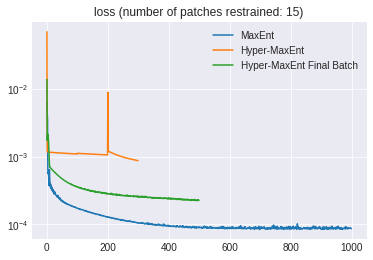

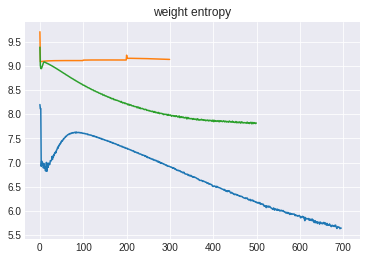

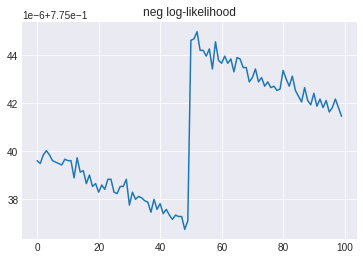

In [40]:
plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(hme_history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

# plt.plot(hme_history.history['loss-from-ref'])
# plt.show()

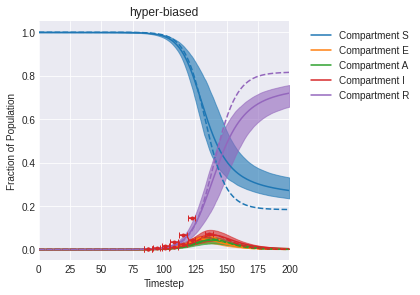

In [41]:
patch_number = 0
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(plt, hme_model.lambdas[i], color='C3')
plt.tight_layout()
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.title('hyper-biased')
plt.show()


## Direct Regression of Model

In [42]:
T = tmat.value
start = np.zeros((M, C))
start[0,1] = 1e-6
infect = maxentep.ContactInfectionLayer(np.array([hyper_pram.beta_start,hyper_pram.beta_start]), infections_compartments, area=area)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, mobility_matrix, T, infect, Time, agreement, populations=population)

In [43]:
rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(150)
rtraj = rmodel.get_traj()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
150/150 [==============================] - 20s 136ms/step - loss: 1.5263 - output_2_loss: 1.5263


## Visualizing results

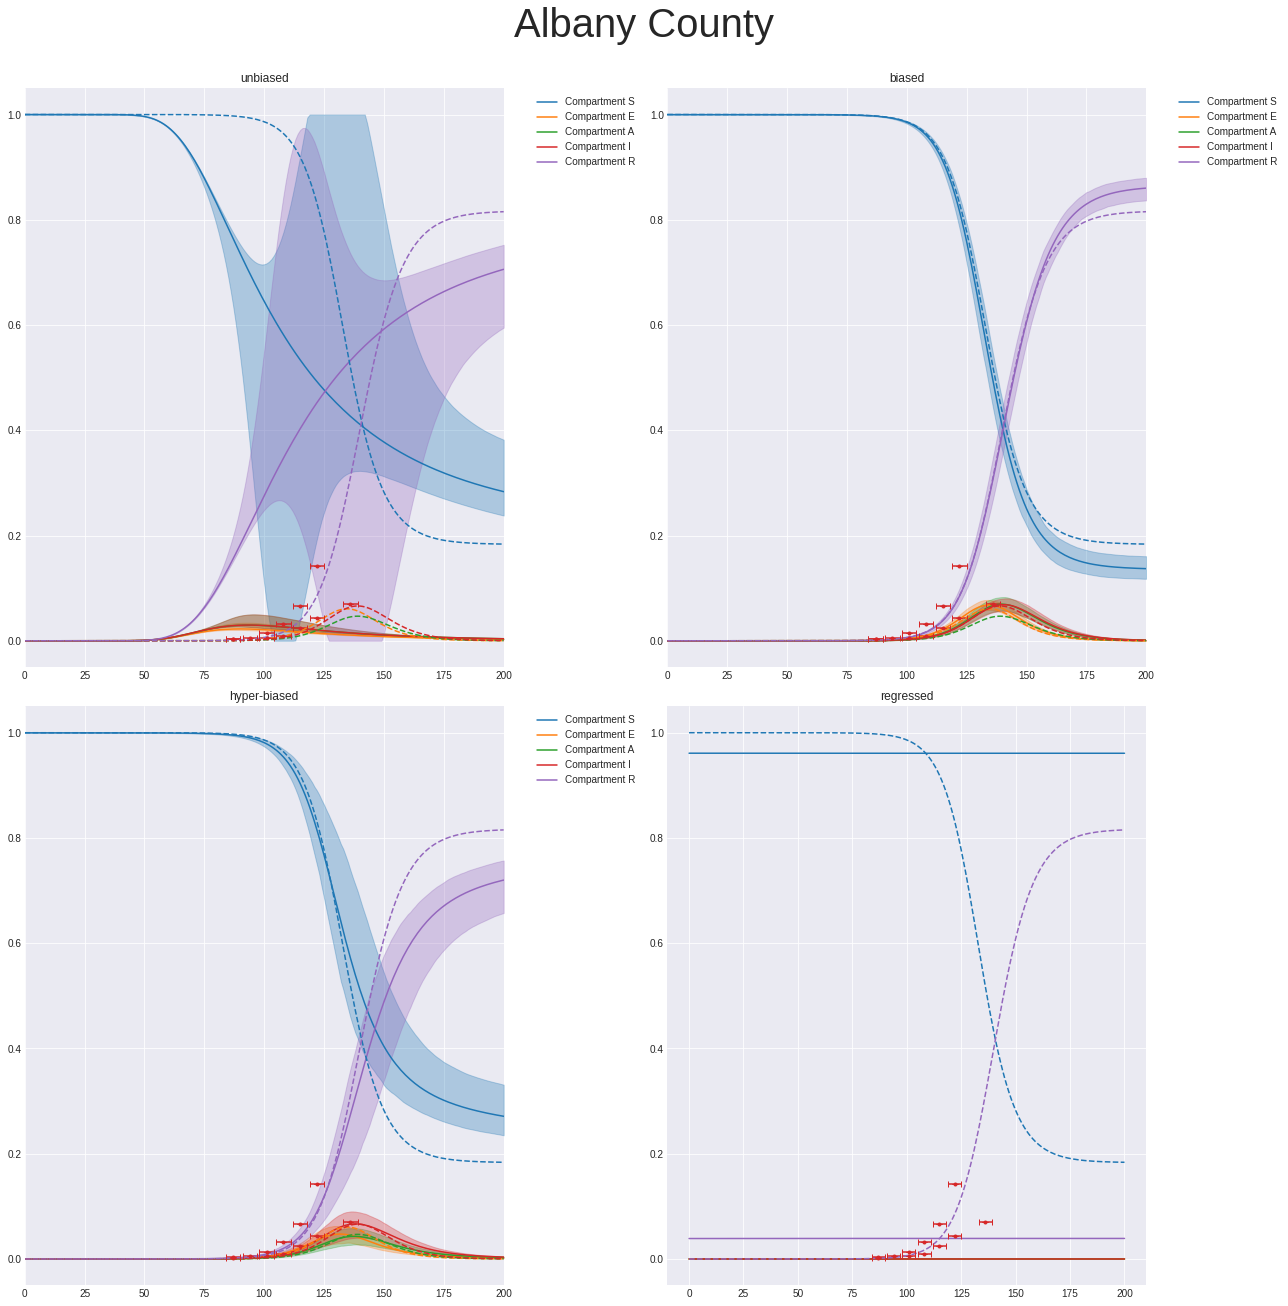

In [44]:
patch_number = 0
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0],alpha = 0.3)
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')

for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments,alpha = 0.3, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], alpha = 0.3,weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,1], 1, color='C3')

    
plt.tight_layout()
# plt.savefig('compare_Albany.png', dpi = 300)
plt.show()
plt.close()

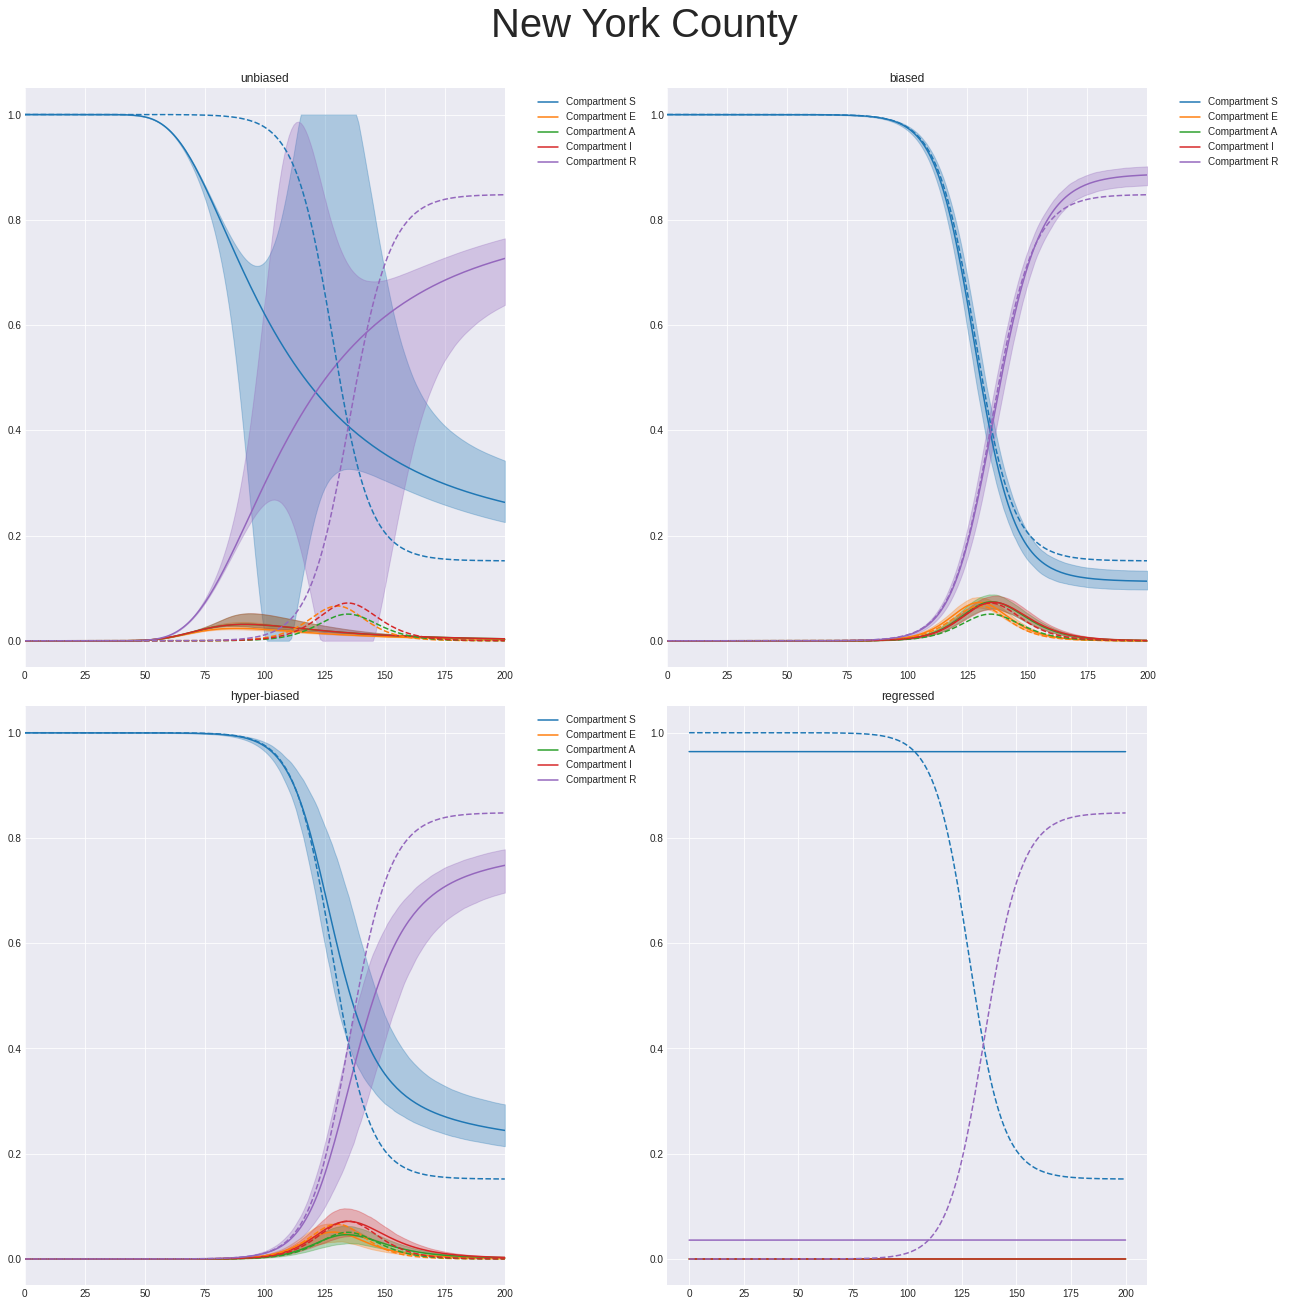

In [45]:
patch_number = 30
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0],alpha = 0.3)
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# ax[0,0].tick_params(color='green', labelcolor='green')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[0,0], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, alpha = 0.3,names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[0,1], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, alpha = 0.3,names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[1,0], hme_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[1,1], 1, color='C3')

plt.tight_layout()
# plt.savefig('compare_NY.png', dpi = 300)
plt.show()
plt.close()

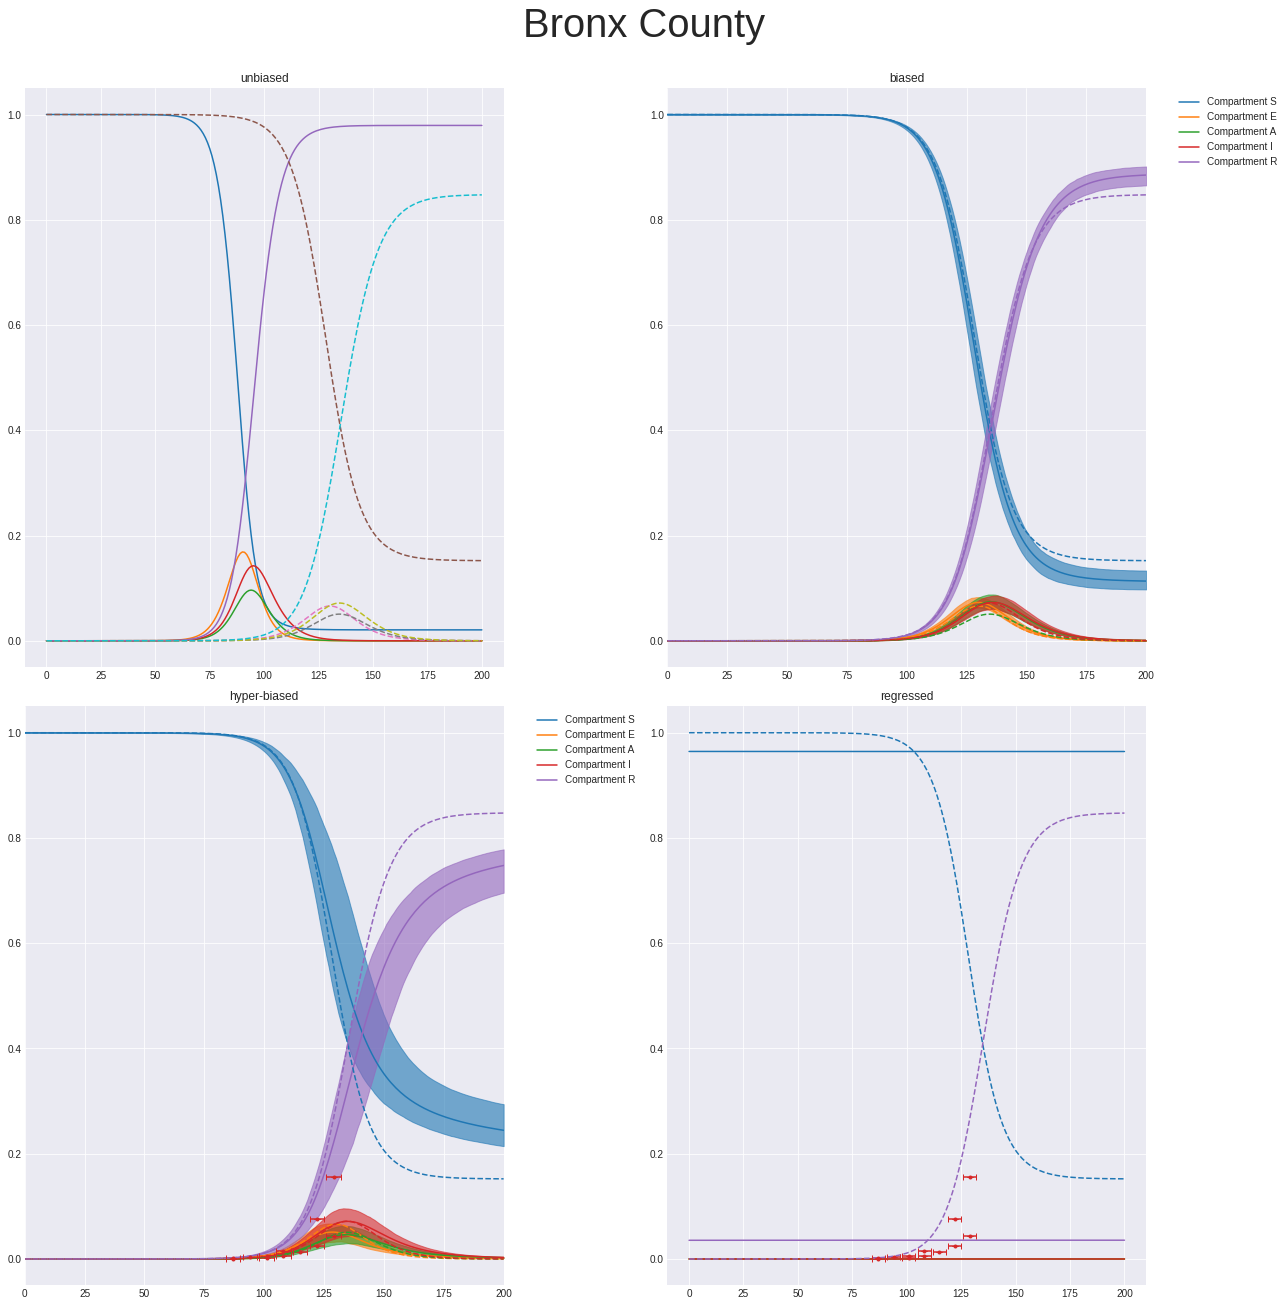

(1, 201, 62, 5)


In [46]:
patch_number = 2
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
axs[0,0].plot(trajs[0,:,patch_number,:])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns_list[patch_number]):
#     pf(axs[0,0], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns_list[patch_number]):
#     pf(axs[0,1], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
plt.savefig('compare_Livingston.png', dpi = 300)
plt.show()
print (ref_traj.shape)

In [56]:
weights_dict = {'unbiased':None, 'biased':me_model.traj_weights, 'hyper-biased':hme_model.traj_weights, 'regression':None }
from matplotlib.patches import Patch
print (restrained_patches)
def compare_patches(ref_traj,trajs,weights_dict, method ,*args, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[p,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
    plt.tight_layout()


NameError: name 'hme_model' is not defined

Plotting 62 patches in a 7 x 9 grid


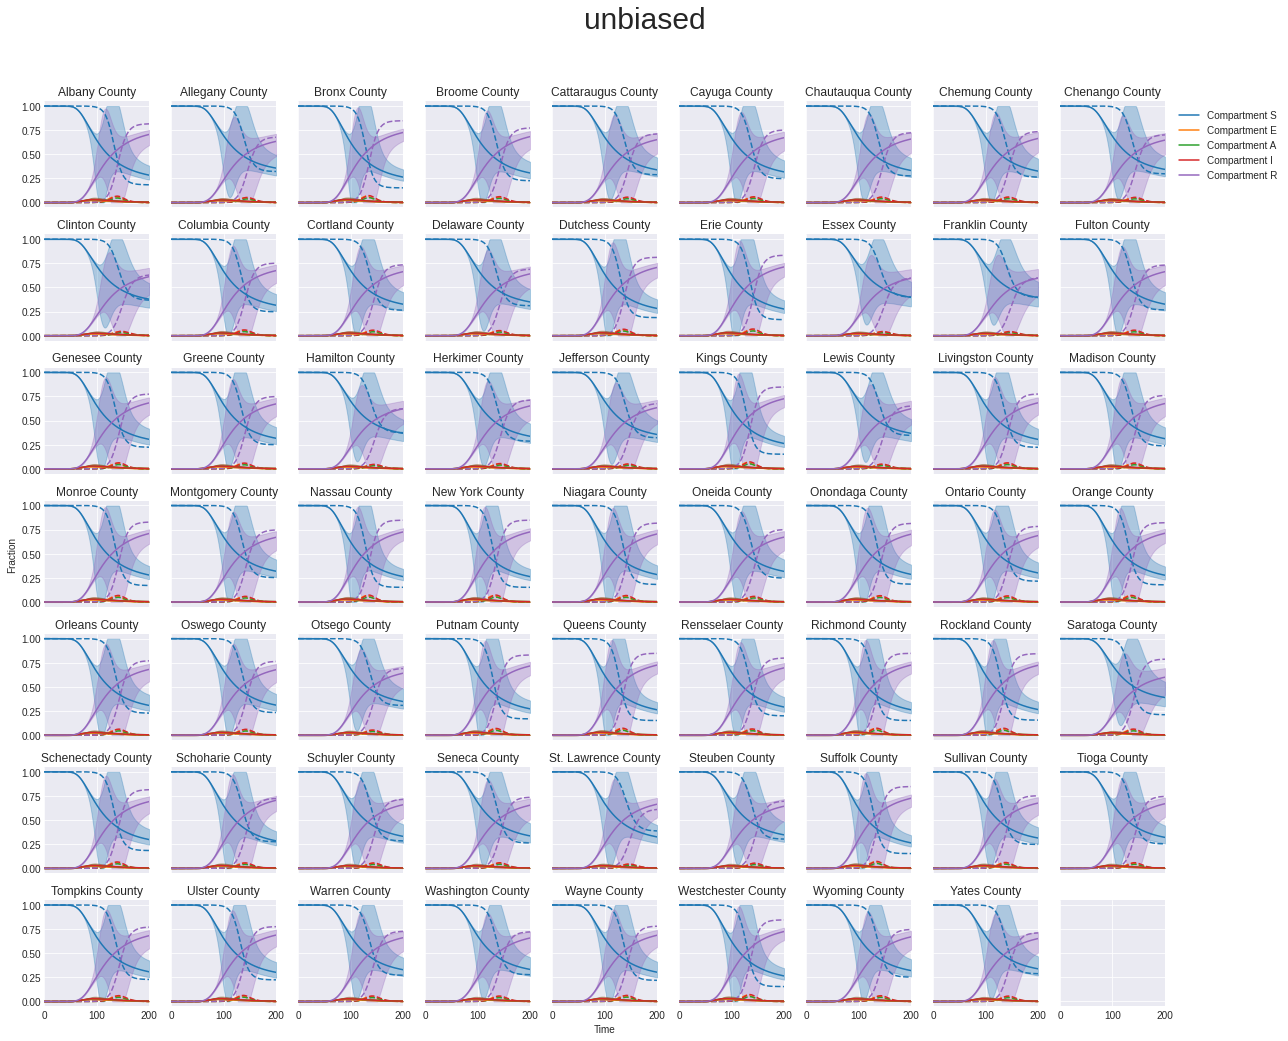

In [48]:
compare_patches(ref_traj,trajs,weights_dict,'unbiased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_unbiased.png',dpi=300)
# (ref_traj, trajs,weights_dict,'biased',patch_names = patches)

Plotting 62 patches in a 7 x 9 grid


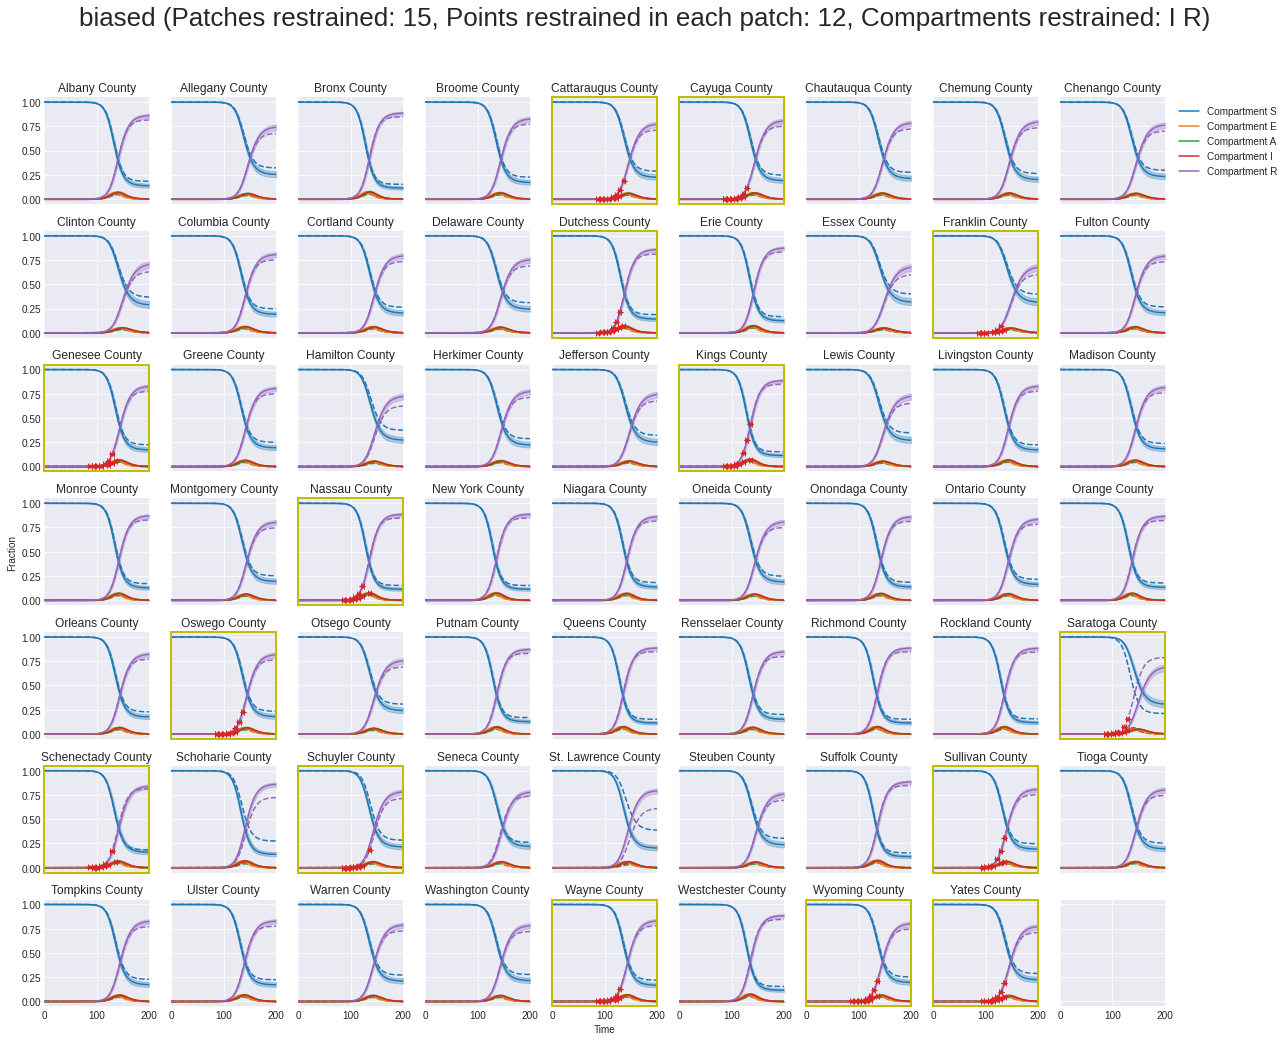

In [49]:
compare_patches(ref_traj,trajs,weights_dict,'biased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_biased_{}_restrained_{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)
# (ref_traj, trajs,weights_dict,'biased',patch_names = patches)

Plotting 62 patches in a 7 x 9 grid


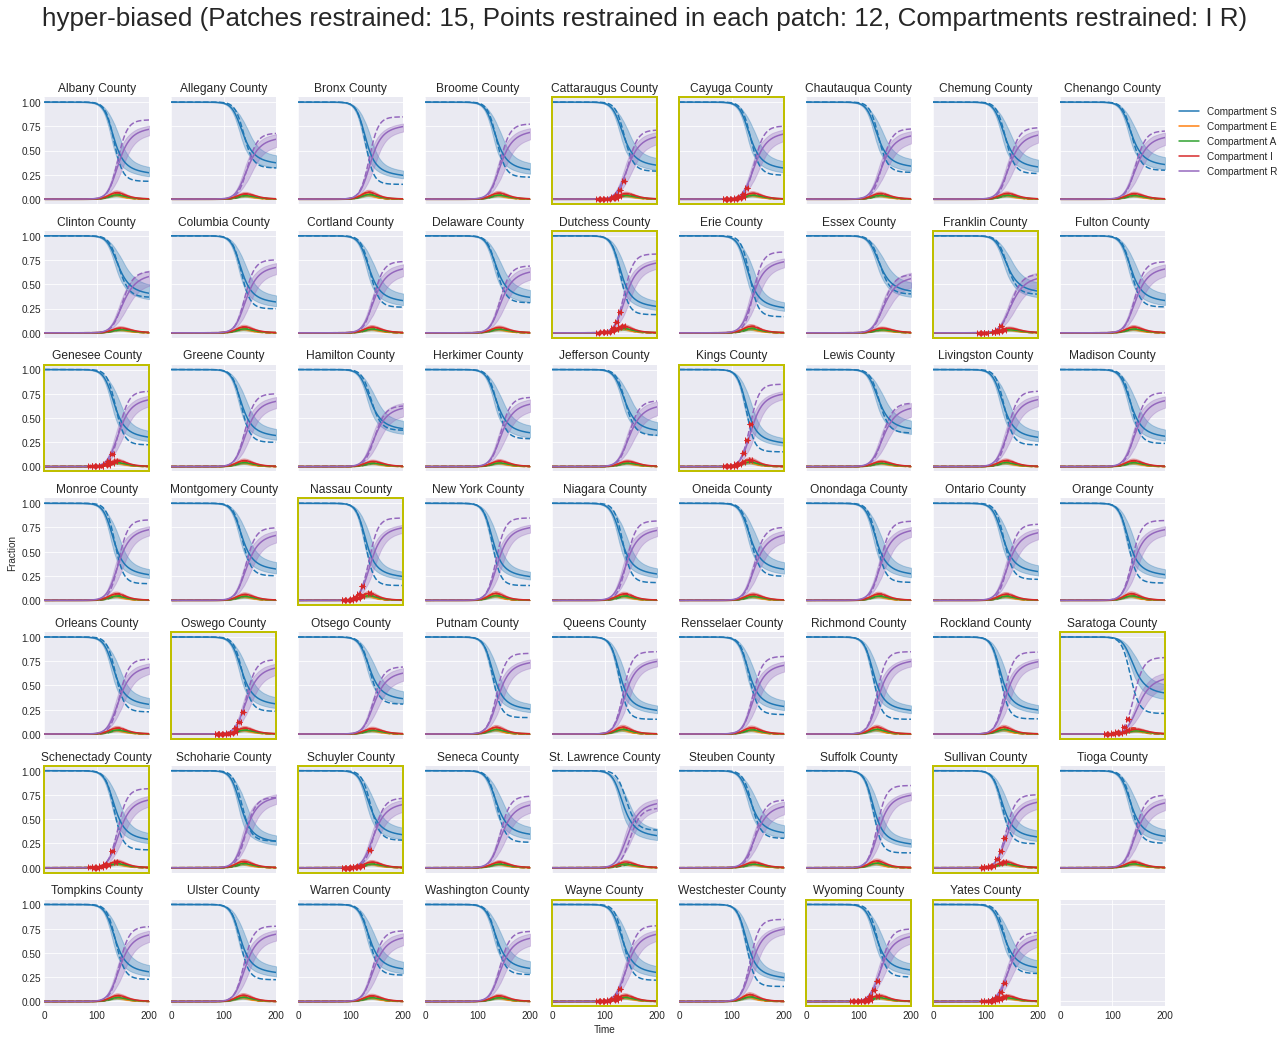

In [50]:
compare_patches(ref_traj,hme_model.trajs,weights_dict,'hyper-biased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_hyper_{}_restrained_{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)

In [51]:
weight_hyper = weights_dict['hyper-biased']
# weight_hyper /=np.sum(weight_hyper)
# mtrajs_patch = np.sum(trajs[:,:,0,:] * weight_hyper[:, np.newaxis, np.newaxis], axis=0)
# print (trajs.shape)
# print (mtrajs_patch.shape)
# print (trajs.shape[2], trajs.shape[-1])
def mean_traj(trajs,weights=None):
    Time = trajs.shape[1]
    c = trajs.shape[-1]
    M = trajs.shape[2]
    if weights is None:
        w = np.ones(trajs.shape[0])
    else:
        w = weights
    w /= np.sum(w)
    mtrajs_counties = np.empty([Time,M,c])
    for i in range(M):
        mtrajs_counties[:,i,:] = np.sum(trajs[:,:,i,:] * w[:, np.newaxis, np.newaxis], axis=0)
    mtrajs = np.sum(mtrajs_counties*population_fraction[np.newaxis, :, np.newaxis],axis=1)
    return mtrajs

    
mtrajs_hyper_biased = mean_traj(hme_model.trajs,weights = weights_dict['hyper-biased'])



mtrajs_biased = mean_traj(trajs,weights = weights_dict['biased'])
mtrajs_unbiased = mean_traj(trajs)
# REF = ref_traj[p,:,:,:]
# REF = np.expand_dims(REF,axis=0)
mref_traj = mean_traj(ref_traj)


mref_traj = mref_traj[:,:5]

loss_unbiased = np.mean((mref_traj- mtrajs_unbiased)**2)
loss_biased = np.mean((mref_traj- mtrajs_biased)**2)
loss_hyper_biased = np.mean((mref_traj- mtrajs_hyper_biased)**2)



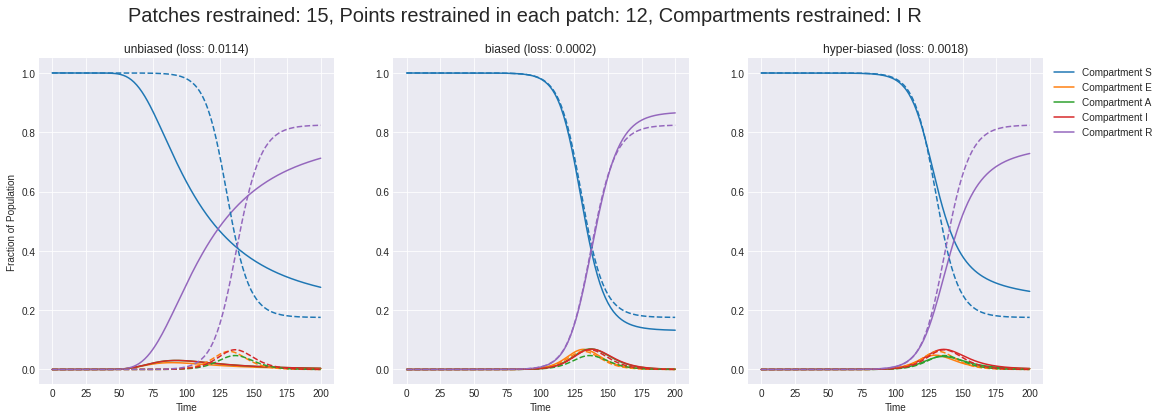

0.9999608502629843


In [52]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
fig.suptitle('Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {}'
             .format(len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names), fontsize=20,y=1.00)

axs[0].set_title('unbiased (loss: {})'.format(np.round(loss_unbiased,4)))
axs[1].set_title('biased (loss: {})'.format(np.round(loss_biased,4)))
axs[2].set_title('hyper-biased (loss: {})'.format(np.round(loss_hyper_biased,4)))
for i in range(mref_traj.shape[-1]):
    axs[0].plot(range(Time),mtrajs_unbiased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')
    axs[1].plot(range(Time),mtrajs_biased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')
    axs[2].plot(range(Time),mtrajs_hyper_biased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')

axs[0].plot(mref_traj,linestyle='--')
axs[1].plot(mref_traj,linestyle='--')
axs[2].plot(mref_traj,linestyle='--')
axs[2].legend(bbox_to_anchor=(1.4, 1))
plt.setp(axs[:], xlabel='Time')
plt.setp(axs[0], ylabel='Fraction of Population')

# plt.tight_layout()
plt.savefig('compare_means_restraints_{}{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)
plt.show()
print (np.sum(mtrajs_biased[-1]))

In [53]:
Loss = np.mean((mref_traj- mtrajs_unbiased)**2)
print (Loss)

# print(end - start)

0.011405003928066974


Plotting 62 patches in a 7 x 9 grid


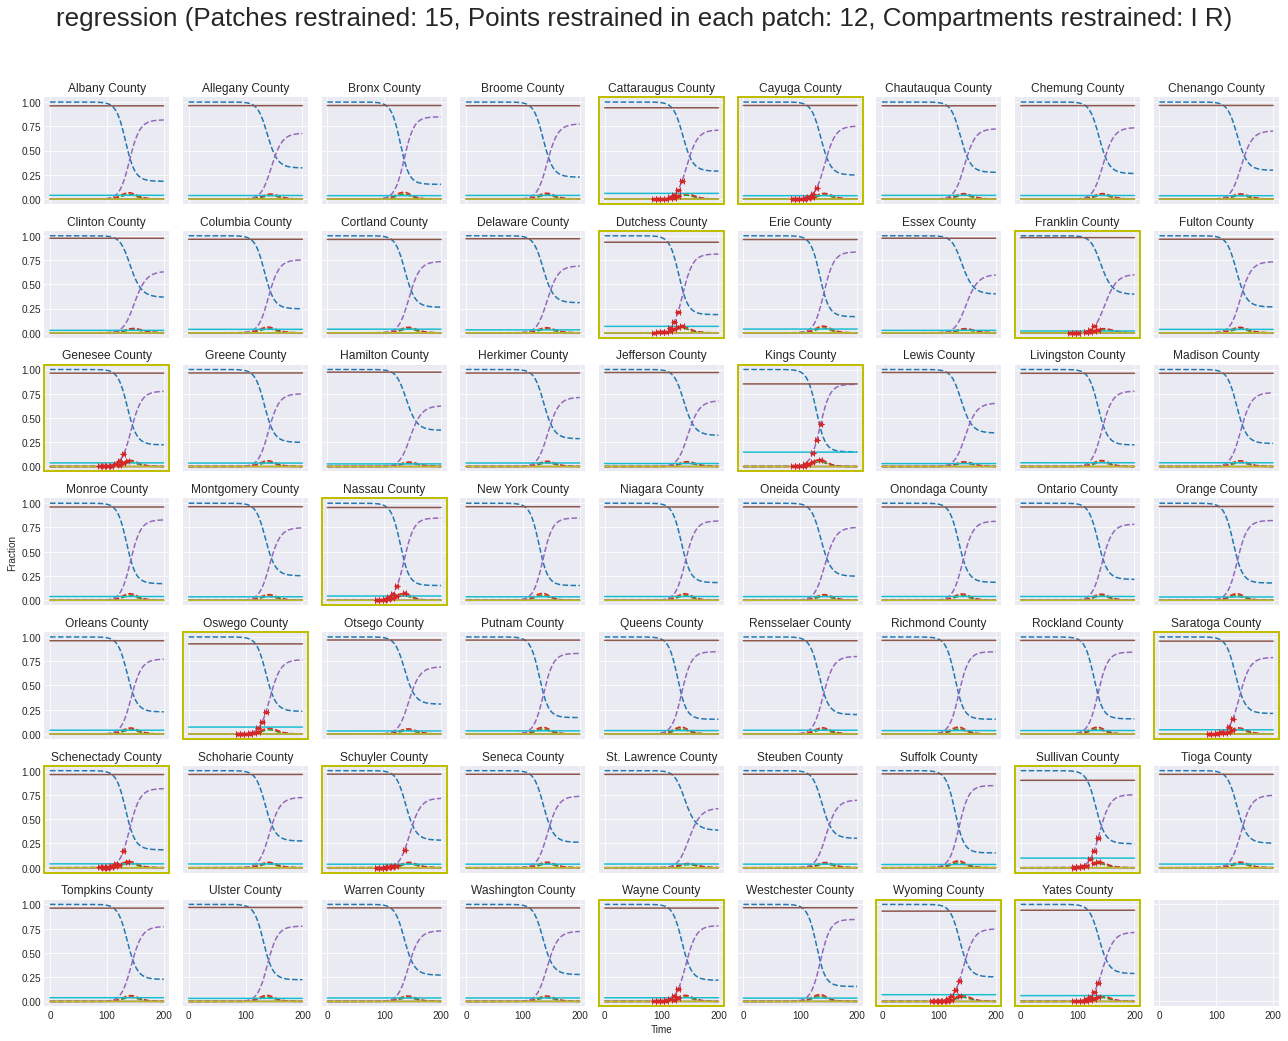

In [54]:
compare_patches(ref_traj,trajs,weights_dict,'regression', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_regression.png',dpi=300)


# Parameter posterior distributions

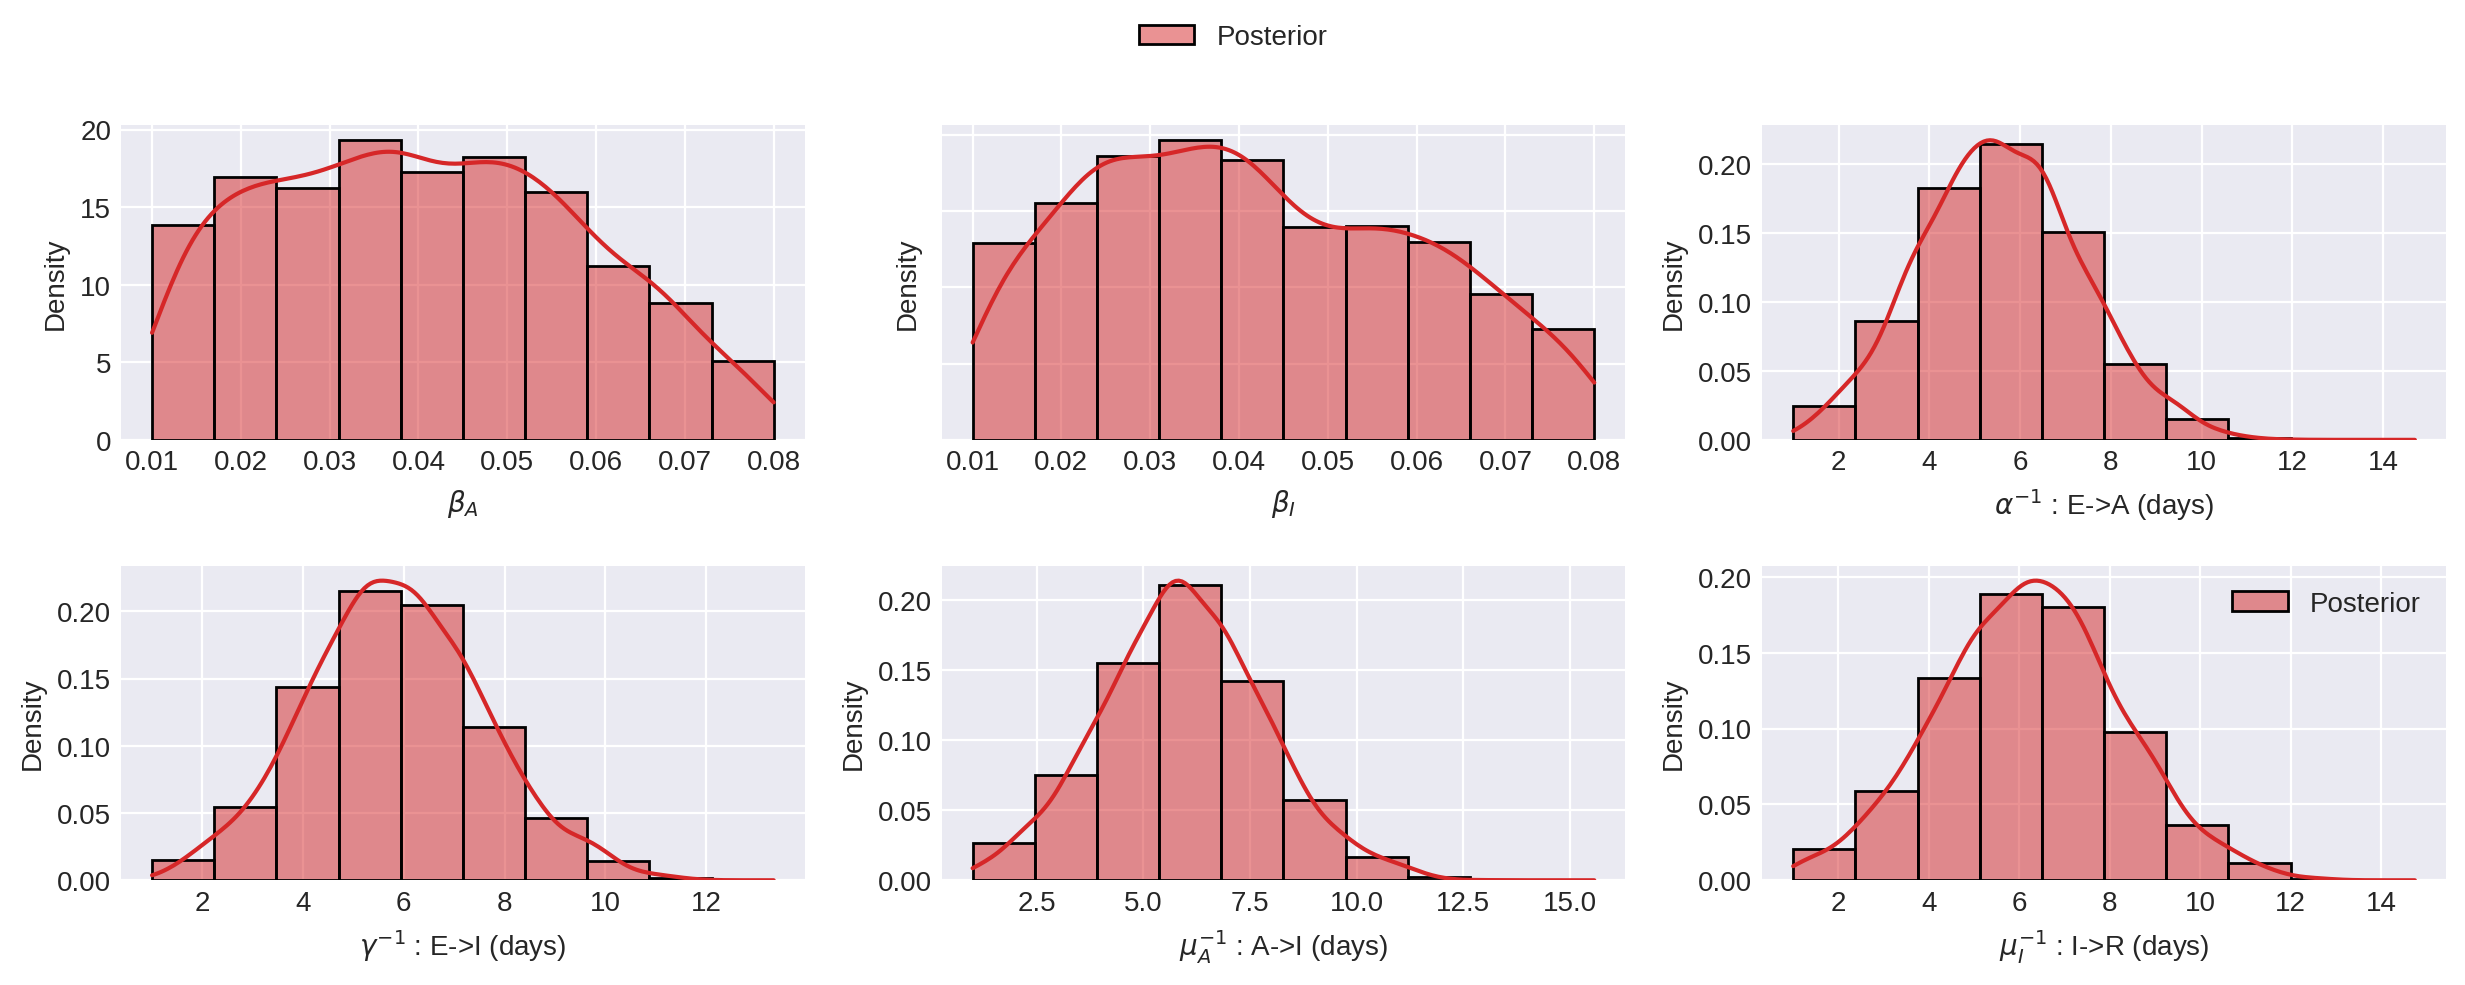

In [55]:
E_A, E_I, A_R, I_R, start_exposed_dist, beta_dist = prior_param_dist
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.histplot(x=np.squeeze(beta_dist[...,0]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0], kde=True, stat="density")
axs[0,0].set_xlabel(r'$\beta_{A}$')

sns.histplot(x=np.squeeze(beta_dist[...,1]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1], kde=True, stat="density")
axs[0,1].set_xlabel(r'$\beta_{I}$')

sns.histplot(x=np.squeeze(E_A), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2], kde=True, stat="density")
axs[0,2].set_xlabel(r'$\alpha^{-1}$ : E->A (days)')

sns.histplot(x=np.squeeze(E_I), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0], kde=True, stat="density")
axs[1,0].set_xlabel(r'$\gamma ^{-1}$ : E->I (days)')

sns.histplot(x=np.squeeze(A_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1], kde=True, stat="density")
axs[1,1].set_xlabel(r'$\mu_{A} ^{-1}$ : A->I (days)')

sns.histplot(x=np.squeeze(I_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,2], kde=True, stat="density")
axs[1,2].set_xlabel(r'$\mu_{I}^{-1}$ : I->R (days)')


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.4)
# axs[-1, -1].axis('off')
axs[0,1].set_yticklabels('')
plt.legend()
# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)

# Compare posterior with prior

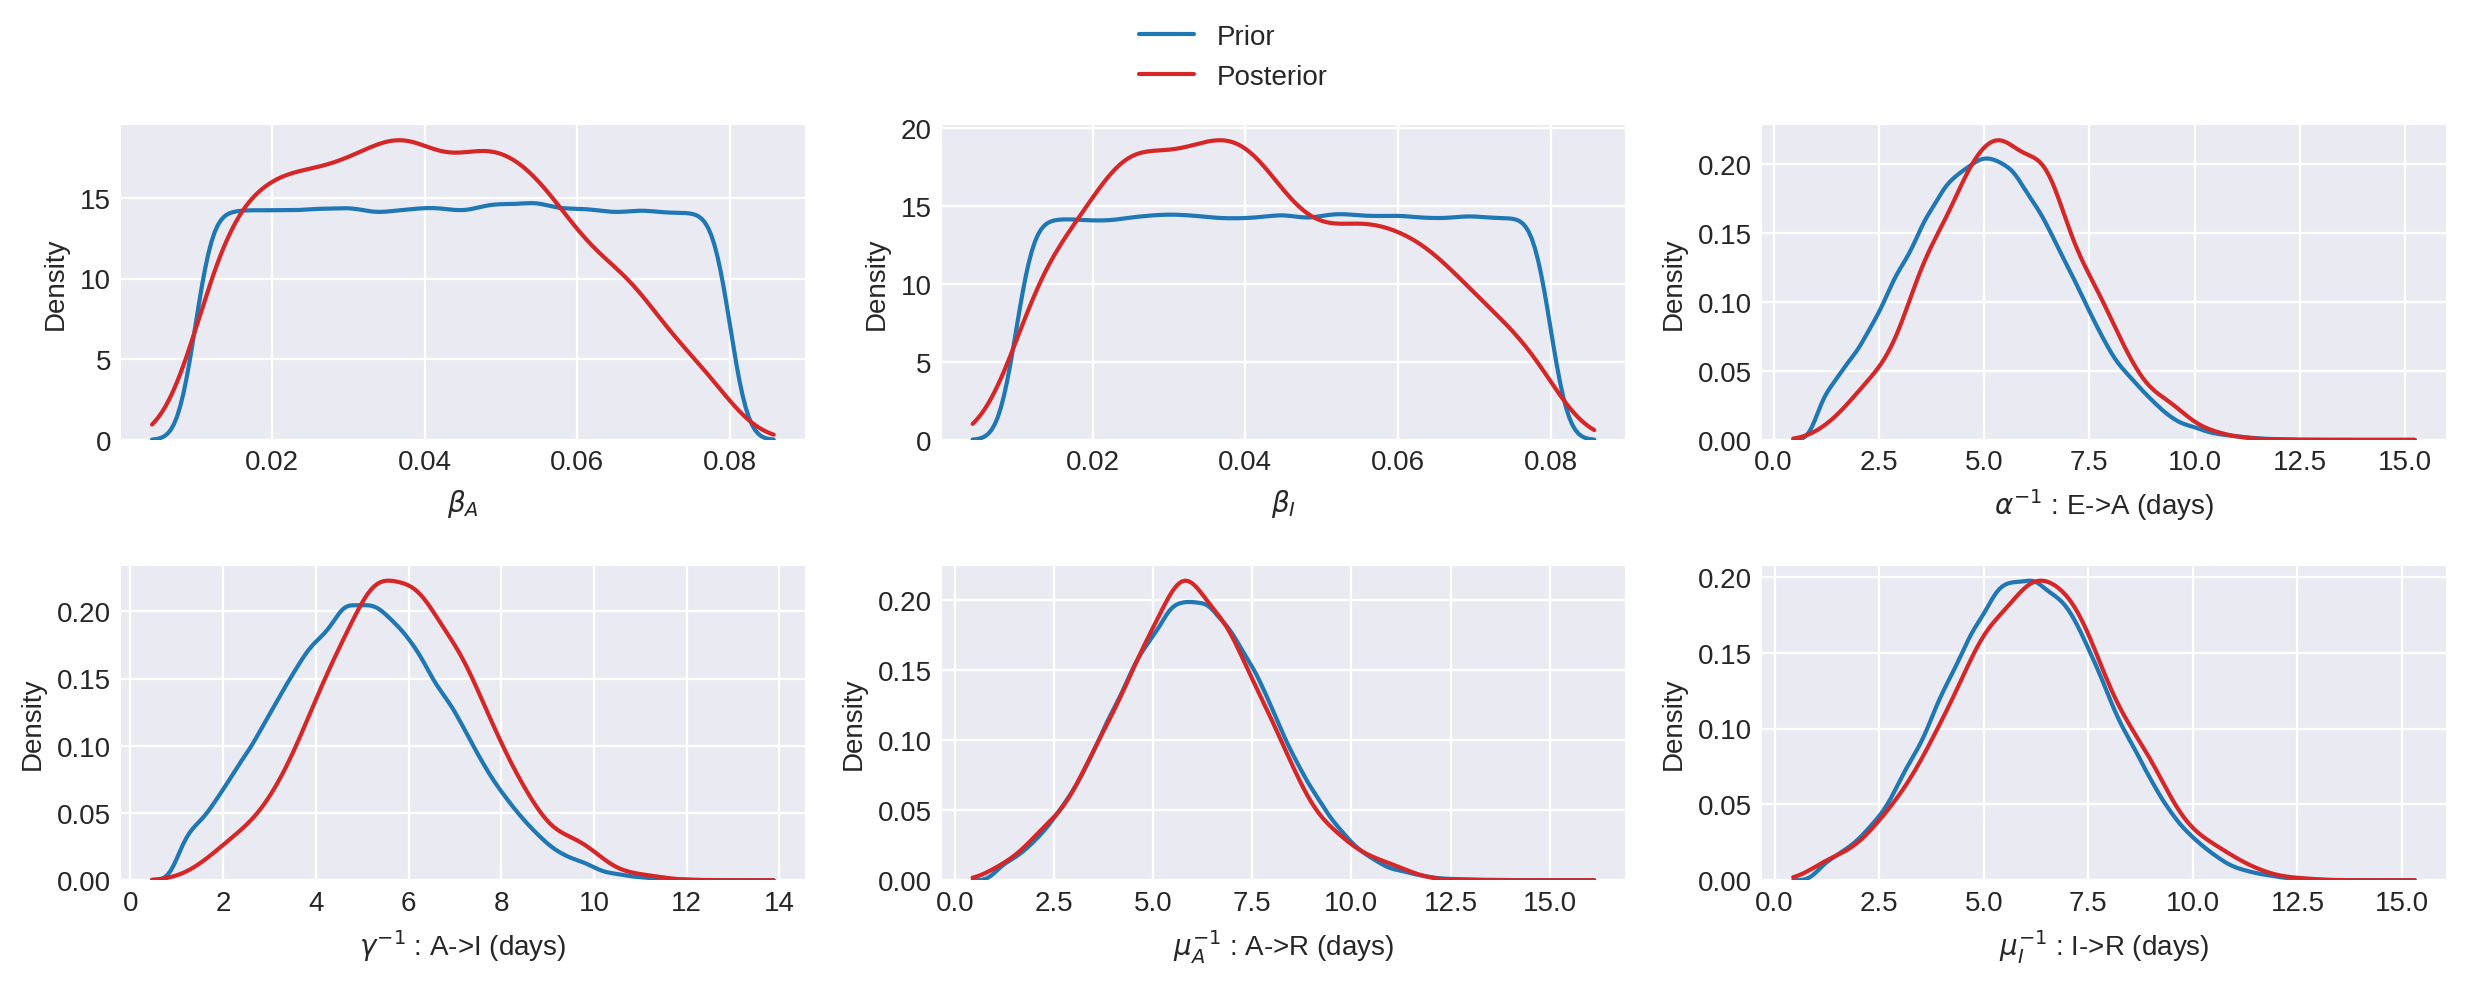

In [56]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.kdeplot(x=np.squeeze(beta_dist[...,0]), label='Prior',
            color='C0', ax=axs[0,0])
sns.kdeplot(x=np.squeeze(beta_dist[...,0]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0])
# sns.histplot(x=np.squeeze(beta_dist), weights=hme_model.traj_weights, label='Posterior',
#             color='C3', ax=axs[0,0], stat="density",kde=True)
axs[0,0].set_xlabel(r'$\beta_{A}$')
sns.kdeplot(x=np.squeeze(beta_dist[...,1]), label='Prior',
            color='C0', ax=axs[0,1])
sns.kdeplot(x=np.squeeze(beta_dist[...,1]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1])
axs[0,1].set_xlabel(r'$\beta_{I}$')

# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)
sns.kdeplot(x=np.squeeze(E_A), label='Prior',
            color='C0', ax=axs[0,2])
sns.kdeplot(x=np.squeeze(E_A), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2])
axs[0,2].set_xlabel(r'$\alpha^{-1}$ : E->A (days)')

sns.kdeplot(x=np.squeeze(E_I), label='Prior',
            color='C0', ax=axs[1,0])
sns.kdeplot(x=np.squeeze(E_I), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0])
axs[1,0].set_xlabel(r'$\gamma ^{-1}$ : A->I (days)')

sns.kdeplot(x=np.squeeze(A_R), label='Prior',
            color='C0', ax=axs[1,1])
sns.kdeplot(x=np.squeeze(A_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1])
axs[1,1].set_xlabel(r'$\mu_{A}^{-1}$ : A->R (days)')

sns.kdeplot(x=np.squeeze(I_R), label='Prior',
            color='C0', ax=axs[1,2])
sns.kdeplot(x=np.squeeze(I_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,2],legend=False)
axs[1,2].set_xlabel(r'$\mu_{I}^{-1}$ : I->R (days)')

handles, labels = axs[0,0].get_legend_handles_labels()
# axs[1,2].get_legend().set_visible(False)
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.4)
# axs[-1, -1].axis('off')
# plt.legend()
plt.savefig('compare_param_dist.png', dpi=300)

In [57]:
me_w = me_model.traj_weights
prior_exposed_patch = maxentep.exposed_finder(trajs)
posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)


In [58]:
# maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=10, figsize=(10,8))
# maxentep.p0_map(prior_exposed_patch, M, weights = me_w, patch_names=patches, title = 'Posterior patient-zero probability', fontsize=10,figsize=(10,8))

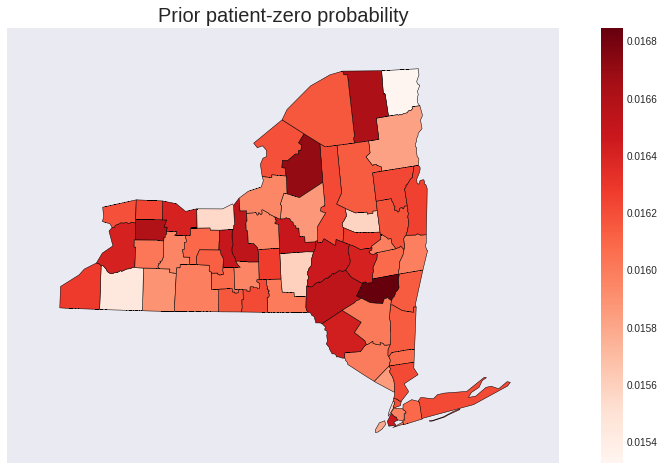

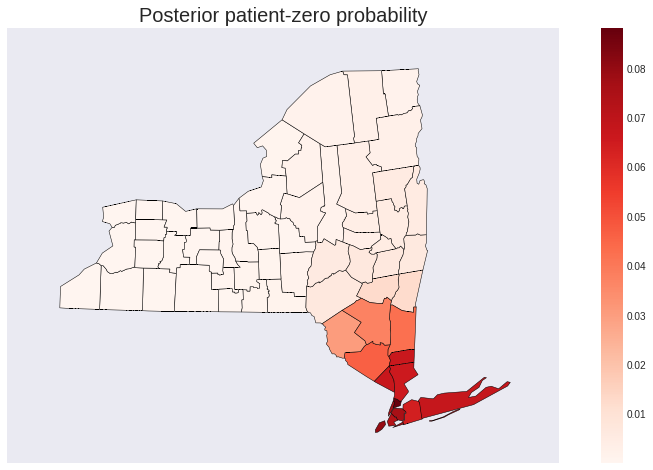

In [59]:
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')
maxentep.p0_map(prior_exposed_patch, M, weights = me_w, title = 'Posterior patient-zero probability', patch_names=patches, fontsize=20
      , choropleth=True, geojson='counties_ny.geojson')

Finding the top 5 most probable locations for the origin of outbreak:

In [60]:
sorted(zip(posterior_exposed_prob, patches), reverse=True)[:5]

[(0.0881743590177121, 'Bronx County'),
 (0.07957934789331197, 'Richmond County'),
 (0.07621159806182672, 'Queens County'),
 (0.07551613739268298, 'New York County'),
 (0.07268364558731596, 'Kings County')]

# Evaluating results

In [61]:
def find_mode(param, weights):
    ax = sns.histplot(x=np.squeeze(param), weights=weights, label='Posterior',
                color='C3', kde=True, stat="density")
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    plt.close()
    return xs[np.argmax(ys)]

In [62]:
maxent_params =[]
for x in [beta_dist[...,1], beta_dist[...,0], E_A, E_I, A_R, I_R]:
    maxent_params.append(find_mode(x,me_w))
beta_I_inferred, beta_A_inferred, alpha_inferred, gamma_inferred, mu_A_inferred, mu_I_inferred  = maxent_prams
# Finding eta and epsilon:
eta_inferred = 1/(1/alpha_inferred + 1/gamma_inferred)
epsilon_inferred = 1 - 1/alpha_inferred * eta_inferred

In [63]:
k = ['beta_I', 'beta_A', 'epsilon', 'eta', 'mu_A', 'mu_I' ]
v = [beta_I_inferred, beta_A_inferred, epsilon_inferred, eta_inferred, mu_A_inferred, mu_I_inferred]
maxent_params_dict = dict(zip(k,np.round(v,3)))

True parameters:

$\beta_{I} = 0.052113$, &nbsp;   $\beta_{A} = 0.028905$, &nbsp;   $\epsilon = 0.586028$, &nbsp; $\eta = 2.492673$,  &nbsp; $\mu = 4.897089$  


Inferred parameters:

In [64]:
maxent_params_dict

{'beta_I': 0.037,
 'beta_A': 0.037,
 'epsilon': 0.488,
 'eta': 2.73,
 'mu_A': 5.833,
 'mu_I': 6.39}

## Theory 1
Basic reproductive number ($R_0$):

$ S \xrightarrow{\beta} E \xrightarrow{\eta} A \xrightarrow{\alpha} I \xrightarrow{\mu} R $

$R_0 = \frac{\beta S_0}{\alpha} +  \frac{\beta S_0}{\mu } $

$ t_{max} \sim \frac{log(S_0)}{\mu (R_0 -1)}$

In [65]:
# total_pop = np.sum(population)
# R0 = beta*total_pop*(1/alpha + 1/mu)

In [66]:
# t_max = np.log(total_pop)/mu/(R0-1)

In [67]:
# t_max